In [238]:
# hand features - every fifth frame,perturb => 5,6 times of the original data , Noisy labels -> Target variable
# 7,8 times of the data : Regressor - Grid search cv, test mse, correlation
# neural network - random shuffle
# Cross validation - mean score
# trainee variance
# mask track rcnn training and map

In [257]:
import os
import cv2
import csv
import glob
import json
import pprint

import sys 

import math
import numpy as np
import pandas as pd

import scipy
import matplotlib.pyplot as plt

import seaborn as sn # for heatmap 
from sklearn.utils import resample

from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.svm import SVC, SVR
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor , AdaBoostClassifier, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

from sklearn.metrics import label_ranking_loss 

from sklearn.model_selection import GridSearchCV
import random
from scipy.stats import pearsonr

from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from numpy.linalg import norm

In [258]:
df = pd.read_csv('./data/expert_scores_trainee_scores.csv')

In [259]:
label_root = "/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/GT_indicator/Experts_GT"

In [260]:
def process_input(input_file):
    next(input_file)
    high,low=0, 0;
    i = 0;
    frame_number, hits, hit_intensity,tug_event, tug, ring_drop_event, jerk, motion_smoothness, time = 0,0,0,0,[],0,0,0,0;
    for row in input_file:
        if i%5: #process every fifth frame
            frame_number = int(row["#"])
            hits = hits + int(row[" H"])

            if int(row[" H"]) and int(row[" HI"]):
                high = high+1
            elif int(row[" H"]) and not int(row[" HI"]):
                low = low+1

            tug.append(int(row[" T"]))

            ring_drop_event = ring_drop_event+int(row[" R"]) 
            jerk = jerk+int(row[" J"])

            if  int(row[" M"]) > motion_smoothness:
                motion_smoothness = int(row[" M"])
        i=i+1

    tug.append(0) #end
    count=0; #000000111100000011000000111110000000
    f = 0
    total = 0
    
    for i in range(len(tug)):
        if tug[i]==1:
            count= count+1;

        if tug[i]==0 and count:
            total=total+count
            count = 0
            tug_event = tug_event +1

    if high > low:
        hit_intensity = 1
    else:
        hit_intensity = 0
    time = frame_number/25
    return(hits, hit_intensity,tug_event, total, jerk, time, ring_drop_event)
    

In [261]:
## MIN MAX SCALLING
def normalize_min_max(a):
    return((a - np.min(a))/np.max(a))

def std_normalize(a):
    return((a - np.mean(a))/np.std(a))

def variance(a):
    return np.var(a)
    
def diff2D(indata) : # (fx+1 -fx)/ 1
    outdata=[]
    for i in range(len(indata)-1): # x_t+1 - x_t , y_t+1 - y_t
            outdata.append((indata[i + 1][0] - indata[i][0], indata[i + 1][1] - indata[i][1])); 
                           
    return outdata


#find curvature
def find_curvature(dx, ddx): #2d vector
    curvature = []
    for i in range(len(dx)-1):
        dd = pow(dx[i][0] * dx[i][0] + dx[i][1] * dx[i][1], 1.5)
        
        if(dd != 0) :
            curvature.append((abs((dx[i][0] * ddx[i][0]) - (dx[i][1] * ddx[i][1])))/ dd); 


    return curvature

#Arclength

def find_path_length(dx):#2d vector
    arc_length = 0
    
    for i in range(len(dx)):
        arc_length = arc_length+ pow((dx[i][0] * dx[i][0])+ (dx[i][1] * dx[i][1]), 0.5); 
        
    return arc_length;

def curvatureMaxnCount(curvature) :
    
    curvatureMax = 0; 
    curvatureMaxCount = 0; 
    
    if len(curvature) > 0:
        curvatureMax = curvature[0];

        for i in range(len(curvature)):

            if(abs(curvature[i]) > curvatureMax):
                curvatureMax = abs(curvature[i]); 

            if (abs(curvature[i]) > 300): #Hyperparameter : Define with respect to angle
                curvatureMaxCount = curvatureMaxCount+1; 

    return(curvatureMax, curvatureMaxCount)

def mean2D(data) : #2d np array input
    
    sumX, sumY = 0, 0;
    meanX, meanY = 0, 0;
    
    if(len(data)):
        for i in range(len(data)):
            sumX = sumX + data[i][0];
            sumY = sumY + data[i][1];

        meanX = sumX / len(data)
        meanY = sumY / len(data)
    
    return (meanX, meanY)

def max2D(data):
    
    maxX, maxY = 0, 0;
    
    if(len(data)):

        maxX = data[0][0];
        maxY = data[0][1];
        
        for i in range(len(data)):
            if (abs(data[i][0]) > maxX):
                maxX = abs(data[i][0]);
        
            if (abs(data[i][1]) > maxY):
                maxY = abs(data[i][1]);
    
    return  maxX, maxY

_
def var2D(indata): #2d np array

    meanX,meanY = 0, 0; 
    sumX, sumY = 0, 0; 
   
    sz = len(indata) - 1; 

    if( sz > 0):
        meanX, meanY = mean2D(indata); 
        
        for i in range(sz):

            sumX = sumX+ (indata[i][0] - meanX) * (indata[i][0] - meanX); 
            sumY = sumY+ (indata[i][1] - meanY) * (indata[i][1] - meanY); 


        sumX = sumX / sz; 

        sumY = sumY / sz; 
    
    return sumX, sumY

#find jerk
def find_jerk_vector(indata) : #2d vector
    jerk = []
    for i in range(len(indata)-3):
            jx = ((indata[i][0]) - (3 * indata[i + 1][0]) + (3 * indata[i + 2][0]) - (indata[i + 3][0]));
            jy = ((indata[i][1]) - (3 * indata[i + 1][1]) + (3 * indata[i + 2][1]) - (indata[i + 3][1]));
            ji = math.sqrt(jx*jx+ jy*jy)
            jerk.append(ji); 
            
    return jerk

def find_motion_smoothness(jerk): #1d vector
    j_tmp = 0
    for i in range(len(jerk)):
        j_tmp = j_tmp + (jerk[i]* jerk[i]); 
    motion_smoothness = math.sqrt (1/2 * j_tmp);
    return motion_smoothness

def find_right_corner(bbox):
    bbox = sorted(bbox,key=lambda x: x[1])[2:]
    
    if bbox[0][0] > bbox[1][0]:
        right_corner = bbox[0]
    else:
        right_corner = bbox[1]
    
    return right_corner[0], right_corner[1]


In [262]:
#data augmentation : tracking perturbation, hit intensity, number of tugs - Add random noise, Noisy label sampling

In [263]:
feature_dict = {}
for lbl_file in sorted(os.listdir(label_root)):
    #print(lbl_file)
    ff = open(label_root+"/"+lbl_file)
    input_file = csv.DictReader(ff) # Ordered Dictionary
    NUMBER_OF_HITS, HIT_INTENSITY, NUMBER_OF_TUG, TOTAL_FRAMES_IN_TUG, NUMBER_OF_JERK, TIME, NUMBER_OF_RINGDROP  = process_input(input_file)
    
    filename = lbl_file.split("_GT")[0]
    feature_dict[filename] = [NUMBER_OF_HITS, HIT_INTENSITY, NUMBER_OF_TUG, TOTAL_FRAMES_IN_TUG, NUMBER_OF_JERK, TIME, NUMBER_OF_RINGDROP]
    
data_gt = pd.DataFrame(feature_dict) 
data_gt = data_gt.transpose()
data_gt.columns = ["NUMBER_OF_HITS", "HIT_INTENSITY", "NUMBER_OF_TUG", "TOTAL_FRAMES_IN_TUG", "NUMBER_OF_JERK", "TIME", "NUMBER_OF_RINGDROP"]

In [264]:
feature_dict

{'E1_t10': [2, 0, 2, 18, 0, 11.96, 0],
 'E1_t11': [1, 1, 1, 15, 0, 12.96, 0],
 'E1_t12': [1, 0, 3, 21, 0, 20.96, 0],
 'E1_t1': [2, 1, 1, 7, 5, 19.96, 0],
 'E1_t2': [0, 0, 1, 3, 0, 10.64, 0],
 'E1_t3': [0, 0, 2, 15, 3, 8.96, 0],
 'E1_t4': [1, 0, 1, 14, 4, 16.84, 0],
 'E1_t5': [1, 0, 1, 12, 3, 11.0, 0],
 'E1_t6': [2, 0, 1, 13, 0, 12.96, 0],
 'E1_t7': [1, 1, 1, 25, 0, 17.76, 0],
 'E1_t8': [1, 0, 3, 10, 0, 12.92, 0],
 'E1_t9': [1, 0, 1, 14, 0, 7.64, 0],
 'E2_t10': [0, 0, 0, 0, 0, 9.56, 0],
 'E2_t11': [2, 0, 1, 6, 0, 20.84, 0],
 'E2_t12': [0, 0, 3, 20, 0, 27.52, 0],
 'E2_t1': [2, 0, 1, 4, 0, 20.0, 0],
 'E2_t2': [2, 0, 2, 34, 0, 19.84, 0],
 'E2_t3': [2, 0, 1, 18, 0, 11.64, 0],
 'E2_t4': [1, 0, 3, 15, 0, 17.64, 0],
 'E2_t5': [1, 0, 0, 0, 0, 11.84, 0],
 'E2_t6': [0, 0, 2, 29, 0, 17.84, 0],
 'E2_t7': [2, 0, 4, 61, 0, 26.84, 0],
 'E2_t8': [1, 0, 0, 0, 0, 16.0, 0],
 'E2_t9': [2, 0, 0, 0, 0, 19.64, 0],
 'E3_t10': [0, 0, 0, 0, 0, 8.76, 0],
 'E3_t11': [1, 0, 2, 19, 0, 15.64, 0],
 'E3_t12': [2, 0, 0,

In [265]:
dir_root = "/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/"

def find_points(Video):
    dir = Video.rsplit("_",1)[0]    
    shapes = {}

    root = os.path.join(dir_root+dir, Video)
    print(root)
    lbl_files = sorted(glob.glob(root+"/*.json"))
    img_files = sorted(glob.glob(root+"/*.jpg"))
    
    for lbl_path in lbl_files:
        ff = open(lbl_path)
        data = json.load(ff)
        img_path= root+"/"+data["imagePath"]

        print(lbl_path)
        print(img_path)
        for s in data["shapes"]:
            label = s["label"]
            if s["label"] not in shapes.keys():
                cnt = s["points"]
                cnt = np.array(cnt, dtype = np.int32)
                
                if label=="tool":
                    rect = cv2.minAreaRect(cnt)
                    box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
                    box = np.int0(box)

                    cX,cY = find_right_corner(box)

                    shapes[s["label"]] = []
                    shapes[s["label"]].append((cX,cY))
                    
                else: 
                    M = cv2.moments(cnt)
                    cX = int(M['m10']/M['m00'])
                    cY = int(M['m01']/M['m00'])
                    shapes[s["label"]] = []
                    shapes[s["label"]].append((cX,cY))

            else:
                cnt = s["points"]
                cnt = np.array(cnt, dtype = np.int32)
                
                if label == "tool":
                    rect = cv2.minAreaRect(cnt)
                    box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
                    box = np.int0(box)

                    cX,cY = find_right_corner(box)

                    shapes[s["label"]].append((cX,cY))
                else:
                                   
                    M = cv2.moments(cnt)
                    cX = int(M['m10']/M['m00'])
                    cY = int(M['m01']/M['m00'])
                    shapes[s["label"]] = []
                    shapes[s["label"]].append((cX,cY))
            
    return shapes


In [266]:
var_data_x={}
var_data_y={}
def random_aug(coordinates, method="None", p_x=5, p_y=5, Video=""):
    data_tracking = {}
    arc_length_data ={}
    curvature_data = {}
    X_data = {}
    Y_data = {}
    X_Y_data = {}
    motion_smoothness_data = {}

    centroids_tool= np.array(coordinates["tool"], dtype = np.int32)
    X,Y = centroids_tool.T
    
    x_norm = normalize_min_max(X) #augmentation method == None
    y_norm = normalize_min_max(Y)
        
    if "replace_X,Y" in method:
        temp = Y #swap
        Y = X
        X = temp
        
        x_norm = normalize_min_max(X) 
        y_norm = normalize_min_max(Y)
        
    elif "norm_l1" in method:
        l1 = norm(X,1)
        X = X / l1
        x_norm = normalize_min_max(X) 

    elif "norm_l2" in method:
        l2 = norm(X,2)
        X = X / l2
        x_norm = normalize_min_max(X) 
        
    elif "add_constant_X" in method:
        X = X+p_x;
        x_norm = normalize_min_max(X) 
    
    elif "add_constant_Y" in method:
        Y = Y+p_y;
        y_norm = normalize_min_max(Y) 
        
    elif "perturb_X" in method:
        perturb_X = np.random.normal(0, p_x, len(X))
        X = X + perturb_X #perturbation
        x_norm = normalize_min_max(X)

    elif "perturb_Y" in method:
        perturb_Y = np.random.normal(0, p_y, len(Y))
        Y = Y + perturb_Y
        y_norm = normalize_min_max(Y)
                

    centroids = np.array(list(zip(x_norm, y_norm)), dtype = np.float)
    diff_data_dx = diff2D(centroids) #gradient
    diff_data_ddx = diff2D(diff_data_dx)

    curvature = find_curvature(diff_data_dx, diff_data_ddx)
    arc_length = find_path_length(diff_data_dx)
    curvatureMax, curvatureMaxCount = curvatureMaxnCount(curvature)

    var_dx, var_dy = var2D(diff_data_dx) #variance of first derivative
    std_xy = math.sqrt(var_dx+var_dy)
    jerk = find_jerk_vector(centroids)
    motion_smoothness = find_motion_smoothness(jerk)

    mean_x = np.mean(x_norm)
    mean_y = np.mean(y_norm)
    var_x = np.var(x_norm)
    var_y = np.var(y_norm)
    
    var_data_x[Video]=var_x
    var_data_y[Video]=var_y
    
    return (std_xy, arc_length, curvatureMaxCount)
    

In [249]:
directory_list= ["E1", "E2", "E3", "E4", "E5", "E6", "T1_1", "T3_2", "T8_1" ] # 
points={}
random.seed(10)

augmentations=["perturb_X"] #"perturb_X", "perturb_Y", "pertub_X,perturb_Y","replace_X,Y", "add_constant_X", "add_constant_Y", "norm_l1", "norm_l2"
for dir in directory_list:
    directory = os.path.join(dir_root,dir)
    for folder in sorted(os.listdir(directory)):
        if ".avi" not in folder and ".xlsx" not in folder:
            
            hand_features = feature_dict[folder]
            feature_dict[folder] = hand_features + list(random_aug(find_points(folder),  method="None", Video=folder))
            
            if "E6" not in folder and "T8" not in folder:
                aug = random.choices(augmentations, k = 1)
                
                for i in range(1):
                    X = hand_features+list(random_aug(find_points(folder ), method=aug[i], Video=folder+"_aug_"+aug[i], p_x=3, p_y=i+1))
                    feature_dict[folder+"_aug_"+aug[i]] = X
#                     perturbation = np.random.normal(0, i, len(X))
#                     X = X + perturbation #perturbation
#                     feature_dict[folder+"_aug_noise_"+aug[i]] =list(X)



/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0006.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0084.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0084.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0085.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0085.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0086.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0086.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0087.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0087.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0088.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0088.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t1/0089.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0006.json
/home/k

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0031.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t10/0036.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0041.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0041.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0042.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t11/0046.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0026.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t12/0009.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t2/0026.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t3/0023.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0016.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0017.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0019.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0077.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t4/0082.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t6/0016.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0006.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0031.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t7/0032.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0050.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t8/0052.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E1/E1_t9/0006.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0040.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0040.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0041.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0041.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0042.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0045.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t1/0049.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0036.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t10/0037.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0076.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0041.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0041.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0042.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t11/0046.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0050.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0054.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0036.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t12/0038.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0023.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0095.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0095.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0096.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0096.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0097.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0097.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0098.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0098.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0099.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0099.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0100.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t2/0100.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t3/0016.json
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0010.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0016.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0017.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t4/0021.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0050.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t5/0051.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0031.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0033.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0039.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0039.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0040.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0040.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0041.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0041.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0042.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t6/0044.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0048.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t7/0008.json
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0029.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t8/0064.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0049.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0082.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0083.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0083.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0084.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0084.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0085.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0085.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0086.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0086.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0087.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E2/E2_t9/0087.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0056.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0076.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0077.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t1/0078.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t11/0006.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0007.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0017.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t12/0022.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0064.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0042.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t2/0047.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t3/0026.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t4/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t4/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t4/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t4/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t4/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t4/0036.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t4/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t4/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t4/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t4/0038.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t4/0039.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t4/0039.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0017.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t5/0022.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t6/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t6/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t6/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t6/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t6/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t6/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t6/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t6/0050.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t6/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t6/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t6/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t6/0052.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0049.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t7/0027.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t8/0059.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t9/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t9/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t9/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t9/0049.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t9/0050.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t9/0050.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t9/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t9/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t9/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t9/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t9/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E3/E3_t9/0053.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0016.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0017.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0076.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0077.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t1/0014.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t10/0023.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0014.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0093.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0093.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0094.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0094.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0095.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0095.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0096.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0096.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0097.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0097.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0098.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t11/0098.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0006.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0094.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0094.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0095.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0095.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0096.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0096.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0097.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0097.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0098.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0098.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0099.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0099.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t12/0031.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0015.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0082.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0083.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0083.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0016.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0017.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t2/0021.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0016.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0077.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t3/0082.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0006.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t4/0006.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0015.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0100.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0100.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0101.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0101.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0102.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0102.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0103.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0103.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0104.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0104.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0105.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0105.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0068.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0068.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0069.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0069.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0070.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0070.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t5/0073.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0064.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0118.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0118.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0119.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0119.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0120.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0120.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0121.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0121.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0122.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0122.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0123.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0123.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0109.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0109.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0110.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0110.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0111.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0111.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0112.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0112.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0113.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0113.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0114.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t6/0114.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0065.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t7/0029.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0016.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0017.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0019.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0118.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0118.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0119.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0119.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0120.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0120.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0121.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0121.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0122.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0122.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0123.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0123.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t8/0027.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0006.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0070.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0070.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0075.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0132.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0132.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0133.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0133.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0134.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0134.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0135.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0135.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0136.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0136.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0137.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0137.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0200.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0200.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0201.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0201.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0202.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0202.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0203.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0203.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0204.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0204.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0205.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0205.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0108.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0108.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0109.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0109.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0110.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0110.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0111.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0111.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0112.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0112.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0113.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E4/E4_t9/0113.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0009.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0031.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t1/0035.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0015.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t10/0016.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0006.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0062.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0067.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0068.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t11/0068.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t12/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t12/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t12/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t12/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t12/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t12/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t12/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t12/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t12/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t12/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t12/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t12/0011.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0014.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0091.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0092.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0092.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0093.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0093.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0094.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0094.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0031.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t2/0033.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0012.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t3/0026.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0009.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0067.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0068.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0068.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0069.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0069.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0070.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0070.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0071.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0040.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0040.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0041.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0041.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0042.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0042.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t4/0045.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0025.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t5/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0004.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0057.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0082.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0083.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0083.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0084.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0084.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0085.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0085.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0086.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t6/0086.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0048.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t7/0024.json
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0012.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0082.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0083.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0083.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0084.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0084.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0085.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0085.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t8/0001.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0006.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0076.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0077.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E5/E5_t9/0079.json
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0017.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0022.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t1/0076.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0006.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t10/0076.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0026.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t11/0076.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0036.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0037.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0092.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0092.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0093.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0093.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0094.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0094.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0095.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0095.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0096.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0096.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0097.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t12/0097.jp

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0006.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0082.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0083.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0083.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0084.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0084.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0085.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0085.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0149.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0149.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0150.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t2/0150.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0004.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0076.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t3/0077.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0048.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0134.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0134.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0135.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0135.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0136.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0136.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0137.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0137.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0138.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0138.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0139.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t4/0139.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0094.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0094.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0095.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0095.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0096.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0096.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0097.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0097.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0098.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0098.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0099.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t5/0099.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0067.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0068.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0068.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0069.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0069.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0070.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0070.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t6/0071.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0066.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0166.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0166.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0167.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0167.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0168.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0168.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0169.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0169.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0170.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0170.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0171.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t7/0171.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0066.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0151.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0151.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0152.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0152.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0153.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0153.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0154.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0154.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0155.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t8/0155.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0001.json
/home/kunaldargan/R

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0067.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0129.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0129.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0130.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0130.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0131.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0131.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0132.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0132.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0133.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0133.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0134.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/E6/E6_t9/0134.jpg
/home/kuna

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0068.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0068.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0069.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0069.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0070.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0070.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0121.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0121.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0122.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0122.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0123.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0123.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0124.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0124.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0125.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0125.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0126.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0179.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0179.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0180.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0180.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0181.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0181.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0182.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0182.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0183.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0183.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0184.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0088.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0088.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0091.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0092.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0092.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0093.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0225.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t1/0225.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0137.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0137.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0138.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0138.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0139.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0139.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0140.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0140.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0141.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0141.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0142.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0128.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0128.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0129.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0129.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0130.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0130.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0131.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0131.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0132.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0132.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t10/0133.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0141.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0141.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0142.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0142.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0143.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0143.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0144.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0144.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0145.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0145.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0146.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/dat

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0114.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0114.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0115.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0115.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0116.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0116.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0117.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0117.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0118.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0118.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t11/0119.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0070.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0070.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0157.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0157.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0158.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0158.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0159.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0159.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0160.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0160.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0161.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0161.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0162.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0231.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0231.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0232.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0232.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0233.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0233.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0234.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0234.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0235.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0235.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0236.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0178.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0178.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0179.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0179.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0180.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0180.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0181.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0181.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0182.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0182.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t12/0183.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0112.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0112.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0113.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0113.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0114.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0114.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0115.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0115.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0116.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0116.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0117.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0178.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0178.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0179.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0179.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0180.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0180.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0181.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0181.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0182.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0182.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0183.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0125.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0125.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0126.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0126.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0127.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0127.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0128.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0128.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0129.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0129.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t2/0130.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0086.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0086.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0087.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0087.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0088.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0088.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0161.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0162.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0162.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0163.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0163.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0164.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0164.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0165.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0165.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0166.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0166.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0076.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0077.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t3/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0082.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0083.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0051.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0051.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0052.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0052.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t4/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0085.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0085.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0086.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0086.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0087.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0087.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0088.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0088.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0180.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0180.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0181.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0181.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0182.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0182.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0183.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0183.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0184.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0184.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0185.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0246.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0246.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0247.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0247.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0248.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0248.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0249.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0249.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0250.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0250.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0251.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0206.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0206.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0207.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0207.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0208.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0208.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0209.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0209.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0210.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0210.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t5/0211.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0067.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0068.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0128.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0128.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0129.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0129.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0130.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0130.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0131.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0131.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0132.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0132.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0133.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0189.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0189.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0190.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0190.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0191.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0191.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0192.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0192.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0193.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0193.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0194.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0166.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0166.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0167.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0167.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0168.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0168.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0169.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0169.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0170.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0170.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t6/0171.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0082.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0083.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0083.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0084.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0148.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0148.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0149.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0149.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0150.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0150.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0151.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0151.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0152.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0152.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0153.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0099.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0099.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0100.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0100.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0101.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0101.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0102.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0102.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0103.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0103.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t7/0104.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0017.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0109.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0110.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0110.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0111.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0111.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0112.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0112.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0113.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0113.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0114.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0114.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0205.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0205.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0206.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0206.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0207.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0207.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0208.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0208.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0209.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0209.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0210.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0154.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0154.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0155.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0155.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0156.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0156.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0157.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0157.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0158.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0158.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t8/0159.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0085.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0085.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0086.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0086.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0087.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0087.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0088.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0088.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0153.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0153.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0154.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0154.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0155.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0155.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0156.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0156.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0157.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0157.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0158.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0224.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0224.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0225.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0225.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0226.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0226.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0227.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0227.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0228.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0228.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0229.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0276.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0276.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0277.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0277.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0278.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0278.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0279.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0279.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0280.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0280.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0281.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0101.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0101.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0102.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0102.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0103.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0103.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0104.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0104.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0105.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0105.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0106.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0192.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0192.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0193.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0193.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0194.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0194.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0195.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0195.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0196.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0196.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0197.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0271.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0271.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0272.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0272.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0273.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0273.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0274.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0274.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0275.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0275.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T1_1/T1_1_t9/0276.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0048.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0049.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t1/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0085.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0085.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0086.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0086.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0087.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0087.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0088.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0088.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0043.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0043.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0044.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0044.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0045.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0045.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0046.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0046.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0047.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0047.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t10/0048.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0036.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0038.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0039.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0039.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0040.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t11/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0069.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0069.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0070.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0070.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0138.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0138.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0139.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0139.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0140.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0140.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0141.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0141.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0142.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0142.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0143.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t12/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t2/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t3/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t4/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0036.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0038.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0039.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t5/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0053.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0053.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0054.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0054.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0055.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0055.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0036.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t6/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0077.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0025.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0026.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0026.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0027.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0027.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0028.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t7/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0076.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0077.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0077.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0016.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0016.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0017.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0017.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t8/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0028.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0029.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0029.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0030.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0030.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0031.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0031.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0032.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0032.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0033.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T3_2/T3_2_t9/0033.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0034.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0034.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0035.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0035.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0036.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0036.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0037.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0037.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0038.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0038.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0039.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0114.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0114.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0115.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0115.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0116.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0116.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0117.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0117.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0118.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0118.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0119.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0176.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0176.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0177.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0177.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0178.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0178.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0179.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0179.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0180.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0180.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t1/0181.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0023.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0024.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0024.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0025.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0112.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0112.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0113.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0113.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0114.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0114.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0115.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0115.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0116.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0116.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t10/0117.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0067.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0068.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0068.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t11/0069.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0006.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0089.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0089.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0090.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0090.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0091.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0091.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0092.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0092.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0093.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0093.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t12/0094.json
/home/kunaldargan/ROBO_SURGERY/MaskRC

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0127.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0127.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0128.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0128.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0129.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0129.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0130.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0130.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0131.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0131.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0132.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0234.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0234.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0235.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0235.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0236.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0236.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0237.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0237.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0238.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0238.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t2/0239.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0018.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0018.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0019.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0019.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0020.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0020.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0021.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0021.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0022.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0022.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0023.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0078.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0078.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0079.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0079.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0080.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0080.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0082.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0083.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0126.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0126.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0127.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0127.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0128.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0128.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0129.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0129.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0130.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0130.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t3/0131.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0065.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0066.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0117.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0117.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0118.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0118.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0119.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0119.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0120.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0120.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0121.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0121.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t4/0122.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0061.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0062.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0062.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0063.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0063.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0064.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0064.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t5/0065.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0006.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0066.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0067.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0067.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0068.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0068.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0069.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0069.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0070.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0070.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t6/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0001.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0001.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0002.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0002.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0003.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0003.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0004.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0004.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0005.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0005.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0071.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0071.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0072.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0072.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0073.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0073.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0074.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0074.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0075.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0075.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t7/0076.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0012.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0013.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0013.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0014.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0014.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0015.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0081.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0081.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0082.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0082.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0083.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0083.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0084.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0084.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0085.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0085.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t8/0086.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0007.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0007.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0008.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0008.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0009.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0009.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0010.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0010.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0011.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0011.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0012.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0056.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0056.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0057.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0057.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0058.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0058.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0059.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0059.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0060.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0060.jpg
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/T8_1/T8_1_t9/0061.json
/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data

In [250]:
i=0
feature_vector = []
with open("./data/aug_features.csv", 'w', newline='') as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["VIDEO","NUMBER_OF_HITS", "HIT_INTENSITY", "NUMBER_OF_TUG", "TOTAL_FRAMES_IN_TUG","NUMBER_OF_JERK_FRAMES", "TIME", "NUMBER_OF_RINGDROP", "VARIANCE", "ARC_LENGTH", "CURVATURE_MAX_COUNT"])
    for key, val in feature_dict.items():
        print(val)
        out_list = [key]+val
        feature_vector.append(out_list)
        i=i+1
        wr.writerow(out_list)

[2, 0, 2, 18, 0, 11.96, 0, 0.05282094094165767, 2.7503501377594097, 1]
[1, 1, 1, 15, 0, 12.96, 0, 0.048059820863831995, 2.638572574106485, 5]
[1, 0, 3, 21, 0, 20.96, 0, 0.03956399638602385, 3.522527520385354, 10]
[2, 1, 1, 7, 5, 19.96, 0, 0.06260897738078354, 3.8744838094886154, 8]
[0, 0, 1, 3, 0, 10.64, 0, 0.03923938382542628, 1.8863963810206368, 7]
[0, 0, 2, 15, 3, 8.96, 0, 0.05892976079342574, 2.0869972332326046, 3]
[1, 0, 1, 14, 4, 16.84, 0, 0.05787762715430274, 3.8584075770165676, 7]
[1, 0, 1, 12, 3, 11.0, 0, 0.061005371390542726, 2.5891913315914277, 4]
[2, 0, 1, 13, 0, 12.96, 0, 0.06229714777023381, 3.3082889447515424, 4]
[1, 1, 1, 25, 0, 17.76, 0, 0.036587170012109343, 2.6820002555854496, 6]
[1, 0, 3, 10, 0, 12.92, 0, 0.04353612400462331, 2.290342647643304, 7]
[1, 0, 1, 14, 0, 7.64, 0, 0.0561779531792063, 1.8399206426439123, 4]
[0, 0, 0, 0, 0, 9.56, 0, 0.06254939261013671, 2.4446903560813973, 4]
[2, 0, 1, 6, 0, 20.84, 0, 0.03291537751528499, 2.8981863730296387, 7]
[0, 0, 3, 20, 

In [251]:
# y_data_val = var_data_y.values()
# plt.figure(figsize=(25,15))
# # plt.bar(list(var_data_y.keys())[400:455],list(var_data_y.values())[400:455] , color='g')
# plt.xticks(rotation=75)
# plt.bar(var_data_y.keys(),var_data_y.values(), color='g')

In [252]:
# len(list(zip(var_data_y.keys(),var_data_y.values()))

In [253]:
feature_dict.keys()

dict_keys(['E1_t10', 'E1_t11', 'E1_t12', 'E1_t1', 'E1_t2', 'E1_t3', 'E1_t4', 'E1_t5', 'E1_t6', 'E1_t7', 'E1_t8', 'E1_t9', 'E2_t10', 'E2_t11', 'E2_t12', 'E2_t1', 'E2_t2', 'E2_t3', 'E2_t4', 'E2_t5', 'E2_t6', 'E2_t7', 'E2_t8', 'E2_t9', 'E3_t10', 'E3_t11', 'E3_t12', 'E3_t1', 'E3_t2', 'E3_t3', 'E3_t4', 'E3_t5', 'E3_t6', 'E3_t7', 'E3_t8', 'E3_t9', 'E4_t10', 'E4_t11', 'E4_t12', 'E4_t1', 'E4_t2', 'E4_t3', 'E4_t4', 'E4_t5', 'E4_t6', 'E4_t7', 'E4_t8', 'E4_t9', 'E5_t10', 'E5_t11', 'E5_t12', 'E5_t1', 'E5_t2', 'E5_t3', 'E5_t4', 'E5_t5', 'E5_t6', 'E5_t7', 'E5_t8', 'E5_t9', 'E6_t10', 'E6_t11', 'E6_t12', 'E6_t1', 'E6_t2', 'E6_t3', 'E6_t4', 'E6_t5', 'E6_t6', 'E6_t7', 'E6_t8', 'E6_t9', 'T1_1_t10', 'T1_1_t11', 'T1_1_t12', 'T1_1_t1', 'T1_1_t2', 'T1_1_t3', 'T1_1_t4', 'T1_1_t5', 'T1_1_t6', 'T1_1_t7', 'T1_1_t8', 'T1_1_t9', 'T3_2_t10', 'T3_2_t11', 'T3_2_t12', 'T3_2_t1', 'T3_2_t2', 'T3_2_t3', 'T3_2_t4', 'T3_2_t5', 'T3_2_t6', 'T3_2_t7', 'T3_2_t8', 'T3_2_t9', 'T8_1_t10', 'T8_1_t11', 'T8_1_t12', 'T8_1_t1', 'T8_1_

# Data Preparation

In [254]:
labels_gt = pd.read_csv('./data/expert_scores_trainee_scores.csv',  index_col="Video")

In [255]:
labels_gt

Hand-eye Coordination  Instrument-Tissue Manipulation  Dexterity  \
Video                                                                        
E1_t1                         3                               3          3   
E1_t2                         3                               3          3   
E1_t3                         4                               3          4   
E1_t4                         3                               2          4   
E1_t5                         3                               3          4   
E1_t6                         3                               3          4   
E1_t7                         4                               4          4   
E1_t8                         3                               3          4   
E1_t9                         4                               4          4   
E1_t10                        4                               3          4   
E1_t11                        4                               3          4   
E1_t12                        4                               2          4   
E2_t1                         4                               4          4   
E2_t2                         4                               3          4   
E2_t3                         4                               4          4   
E2_t4                         4                               3          4   
E2_t5                         4                               4          4   
E2_t6                         3                               3          4   
E2_t7                         3                               3          4   
E2_t8                         4                               4          4   
E2_t9                         4                               4          4   
E2_t10                        4                               4          4   
E2_t11                        4                               3          4   
E2_t12                        3                               3          4   
E3_t1                         4                               3          4   
E3_t2                         4                               3          4   
E3_t3                         4                               4          4   
E3_t4                         4                               3          4   
E3_t5                         4                               3          4   
E3_t6                         4                               3          4   
...                         ...                             ...        ...   
T1_1_t7                       1                               1          1   
T1_1_t8                       1                               1          1   
T1_1_t9                       1                               1          2   
T1_1_t10                      2                               3          2   
T1_1_t11                      3                               3          3   
T1_1_t12                      2                               2          3   
T3_2_t1                       3                               3          3   
T3_2_t2                       3                               3          3   
T3_2_t3                       3                               3          4   
T3_2_t4                       3                               3          3   
T3_2_t5                       4                               3          4   
T3_2_t6                       3                               3          3   
T3_2_t7                       3                               3          3   
T3_2_t8                       3                               3          2   
T3_2_t9                       3                               3          3   
T3_2_t10                      3                               3          3   
T3_2_t11                      3                               2          3   
T3_2_t12                      3                               3          3   
T8_1_t1                       2 

In [256]:
data_gt = pd.read_csv("./data/aug_features.csv", index_col="VIDEO")

In [168]:
target = labels_gt.copy()
for idx in data_gt.index:
    y_index= idx.split("_aug_")[0]
    label_val = labels_gt.loc[y_index]
    target.loc[idx] = label_val

In [169]:
len(data_gt),len(target)

(108, 108)

In [170]:
drop = []
for i, idx in enumerate(data_gt.index):
    if "E6" in idx:
        drop.append(idx)
    

In [171]:
drop

['E6_t10',
 'E6_t11',
 'E6_t12',
 'E6_t1',
 'E6_t2',
 'E6_t3',
 'E6_t4',
 'E6_t5',
 'E6_t6',
 'E6_t7',
 'E6_t8',
 'E6_t9']

In [172]:
data_gt=data_gt.drop(drop) #drop E6

In [173]:
target = target.drop(drop) #drop E6

In [174]:
TEST_SET = ["T"] #Selecting random test set "E6"
print(labels_gt.index)

TEST_VIDEOS = []
TRAIN_VIDEOS = []

for label in target.index:
    for val in TEST_SET:
        if val in label:
            TEST_VIDEOS.append(label)
TRAIN_VIDEOS = sorted(list(set(target.index).difference(set(TEST_VIDEOS))))



Index(['E1_t1', 'E1_t2', 'E1_t3', 'E1_t4', 'E1_t5', 'E1_t6', 'E1_t7', 'E1_t8',
       'E1_t9', 'E1_t10',
       ...
       'T8_1_t3', 'T8_1_t4', 'T8_1_t5', 'T8_1_t6', 'T8_1_t7', 'T8_1_t8',
       'T8_1_t9', 'T8_1_t10', 'T8_1_t11', 'T8_1_t12'],
      dtype='object', name='Video', length=108)


In [175]:
TRAIN_VIDEOS

['E1_t1',
 'E1_t10',
 'E1_t11',
 'E1_t12',
 'E1_t2',
 'E1_t3',
 'E1_t4',
 'E1_t5',
 'E1_t6',
 'E1_t7',
 'E1_t8',
 'E1_t9',
 'E2_t1',
 'E2_t10',
 'E2_t11',
 'E2_t12',
 'E2_t2',
 'E2_t3',
 'E2_t4',
 'E2_t5',
 'E2_t6',
 'E2_t7',
 'E2_t8',
 'E2_t9',
 'E3_t1',
 'E3_t10',
 'E3_t11',
 'E3_t12',
 'E3_t2',
 'E3_t3',
 'E3_t4',
 'E3_t5',
 'E3_t6',
 'E3_t7',
 'E3_t8',
 'E3_t9',
 'E4_t1',
 'E4_t10',
 'E4_t11',
 'E4_t12',
 'E4_t2',
 'E4_t3',
 'E4_t4',
 'E4_t5',
 'E4_t6',
 'E4_t7',
 'E4_t8',
 'E4_t9',
 'E5_t1',
 'E5_t10',
 'E5_t11',
 'E5_t12',
 'E5_t2',
 'E5_t3',
 'E5_t4',
 'E5_t5',
 'E5_t6',
 'E5_t7',
 'E5_t8',
 'E5_t9']

In [176]:
random.seed(0)
random.seed(100)

TESTING_SELECT=random.choices(TEST_VIDEOS, k=12)
TRAINEE_VIDEOS = set(TEST_VIDEOS).difference(TESTING_SELECT)

TESTING_SELECT_EX=random.choices(TRAIN_VIDEOS, k=12)
EXPERT_VIDEOS = set(TRAIN_VIDEOS).difference(TESTING_SELECT_EX)

In [177]:
TRAINEE_VIDEOS

{'T1_1_t1',
 'T1_1_t10',
 'T1_1_t11',
 'T1_1_t12',
 'T1_1_t4',
 'T1_1_t5',
 'T1_1_t7',
 'T1_1_t8',
 'T1_1_t9',
 'T3_2_t1',
 'T3_2_t10',
 'T3_2_t11',
 'T3_2_t12',
 'T3_2_t2',
 'T3_2_t3',
 'T3_2_t6',
 'T3_2_t7',
 'T3_2_t9',
 'T8_1_t1',
 'T8_1_t11',
 'T8_1_t12',
 'T8_1_t6',
 'T8_1_t7',
 'T8_1_t8',
 'T8_1_t9'}

In [178]:
TESTING_SELECT

['T1_1_t6',
 'T3_2_t5',
 'T8_1_t4',
 'T8_1_t2',
 'T8_1_t3',
 'T3_2_t4',
 'T8_1_t5',
 'T3_2_t8',
 'T1_1_t3',
 'T3_2_t5',
 'T1_1_t2',
 'T8_1_t10']

In [180]:
EXPERT_VIDEOS

{'E1_t1',
 'E1_t10',
 'E1_t11',
 'E1_t12',
 'E1_t2',
 'E1_t3',
 'E1_t4',
 'E1_t5',
 'E1_t6',
 'E1_t7',
 'E2_t10',
 'E2_t11',
 'E2_t12',
 'E2_t2',
 'E2_t3',
 'E2_t5',
 'E2_t7',
 'E2_t8',
 'E2_t9',
 'E3_t1',
 'E3_t10',
 'E3_t11',
 'E3_t12',
 'E3_t2',
 'E3_t3',
 'E3_t4',
 'E3_t5',
 'E3_t6',
 'E3_t7',
 'E3_t8',
 'E3_t9',
 'E4_t1',
 'E4_t11',
 'E4_t12',
 'E4_t2',
 'E4_t3',
 'E4_t4',
 'E4_t5',
 'E4_t6',
 'E4_t7',
 'E4_t9',
 'E5_t1',
 'E5_t10',
 'E5_t11',
 'E5_t12',
 'E5_t2',
 'E5_t3',
 'E5_t4',
 'E5_t5',
 'E5_t8',
 'E5_t9'}

In [179]:
TESTING_SELECT_EX

['E5_t6',
 'E2_t6',
 'E2_t4',
 'E4_t8',
 'E2_t1',
 'E1_t8',
 'E1_t9',
 'E2_t6',
 'E4_t10',
 'E5_t7',
 'E2_t1',
 'E5_t7']

In [183]:
EXPERT_VIDEOS = list(EXPERT_VIDEOS)
TRAINEE_VIDEOS = list(TRAINEE_VIDEOS)

In [184]:
EXPERT_VIDEOS = EXPERT_VIDEOS + TRAINEE_VIDEOS

In [185]:
TESTING_SELECT = list(TESTING_SELECT) 
TESTING_SELECT_EX = list(TESTING_SELECT_EX)

In [186]:
TESTING_SELECT = TESTING_SELECT + TESTING_SELECT_EX

In [187]:
X_train = data_gt.ix[EXPERT_VIDEOS]
Y_train = target.ix[EXPERT_VIDEOS]
X_test =  data_gt.ix[TESTING_SELECT]
Y_test = target.ix[TESTING_SELECT]

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  Thi

In [188]:
len(X_train), len(Y_train)

(76, 76)

In [189]:
X_train

NUMBER_OF_HITS  HIT_INTENSITY  NUMBER_OF_TUG  TOTAL_FRAMES_IN_TUG  \
VIDEO                                                                         
E3_t3                  1              0              0                    0   
E5_t5                  1              0              0                    0   
E2_t8                  2              0              0                    0   
E1_t6                  2              0              1                   16   
E5_t8                  2              0              1                   16   
E4_t1                  1              0              1                   29   
E5_t10                 1              0              0                    0   
E4_t9                  3              0              0                    0   
E3_t6                  0              0              3                    6   
E5_t12                 2              0              0                    0   
E5_t1                  0              0              1                    2   
E5_t3                  2              0              0                    0   
E5_t4                  2              0              2                   28   
E3_t9                  1              0              1                    2   
E5_t9                  2              1              1                   23   
E1_t4                  1              0              1                   17   
E2_t7                  2              0              4                   76   
E2_t2                  2              0              2                   42   
E3_t12                 2              0              0                    0   
E4_t7                  2              1              0                    0   
E3_t1                  1              0              1                   21   
E2_t10                 0              0              0                    0   
E3_t4                  2              0              2                   21   
E4_t2                  2              0              0                    0   
E3_t11                 2              0              2                   24   
E2_t11                 2              0              1                    8   
E1_t3                  0              0              2                   19   
E5_t11                 2              0              1                   17   
E1_t1                  2              1              1                    9   
E3_t5                  1              0              1                    2   
...                  ...            ...            ...                  ...   
E1_t10                 2              0              2                   23   
E4_t5                  1              0              0                    0   
E4_t4                  2              0              1                    3   
E1_t12                 2              0              3                   26   
E1_t2                  0              0              1                    3   
T1_1_t4                1              0              1                   12   
T1_1_t8                0              0              3                    3   
T3_2_t6                3              0              1                    9   
T1_1_t9                2              0              0                    0   
T8_1_t11               1              0              0                    0   
T3_2_t2                2              0              0                    0   
T3_2_t9                1              0              0                    0   
T8_1_t1                2              0              0                    0   
T1_1_t11               1              0              0                    0   
T3_2_t1                2              0              0                    0   
T8_1_t8                1              0              0                    0   
T1_1_t1                3              0              1                    2   
T1_1_t10               1              0              0      

In [190]:
X_test

NUMBER_OF_HITS  HIT_INTENSITY  NUMBER_OF_TUG  TOTAL_FRAMES_IN_TUG  \
VIDEO                                                                         
T1_1_t6                4              0              0                    0   
T3_2_t5                0              0              0                    0   
T8_1_t4                3              0              1                   21   
T8_1_t2                2              0              1                   27   
T8_1_t3                0              0              0                    0   
T3_2_t4                1              0              0                    0   
T8_1_t5                0              0              0                    0   
T3_2_t8                0              0              0                    0   
T1_1_t3                2              0              1                    9   
T3_2_t5                0              0              0                    0   
T1_1_t2                1              0              2                   59   
T8_1_t10               2              0              1                    4   
E5_t6                  1              0              2                   18   
E2_t6                  1              0              2                   37   
E2_t4                  1              0              3                   18   
E4_t8                  1              0              0                    0   
E2_t1                  2              0              1                    5   
E1_t8                  1              0              3                   12   
E1_t9                  1              0              1                   18   
E2_t6                  1              0              2                   37   
E4_t10                 3              0              1                    2   
E5_t7                  4              0              6                  108   
E2_t1                  2              0              1                    5   
E5_t7                  4              0              6                  108   

          NUMBER_OF_JERK_FRAMES   TIME  NUMBER_OF_RINGDROP  VARIANCE  \
VIDEO                                                                  
T1_1_t6                       9  49.72                   0  0.040733   
T3_2_t5                       0  13.72                   0  0.068251   
T8_1_t4                       3  32.72                   0  0.035629   
T8_1_t2                       0  53.76                   0  0.027725   
T8_1_t3                       0  29.00                   0  0.067421   
T3_2_t4                       1  15.60                   0  0.048022   
T8_1_t5                       3  26.60                   0  0.050109   
T3_2_t8                       2  28.60                   0  0.032994   
T1_1_t3                       1  39.60                   0  0.022310   
T3_2_t5                       0  13.72                   0  0.068251   
T1_1_t2                       0  52.88                   0  0.026021   
T8_1_t10                      0  23.84                   0  0.029878   
E5_t6                         8  21.56                   0  0.058357   
E2_t6                         0  17.84                   0  0.049078   
E2_t4                         0  17.68                   0  0.041324   
E4_t8                         1  36.80                   0  0.037127   
E2_t1                         0  20.00                   0  0.045962   
E1_t8                         0  12.92                   0  0.043536   
E1_t9                         0   7.64                   0  0.056178   
E2_t6                         0  17.84                   0  0.049078   
E4_t10                        7  14.64                   0  0.060528   
E5_t7                         6  21.56                   0  0.049275   
E2_t1                         0  20.00                   0  0.045962   
E5_t7                         6  21.56                   0  0.049275   

          ARC_LENGTH  CURVATURE_MAX_COUNT  
VIDEO                                 

# Upsample and Class balancing

In [76]:
def upsample_data(data_X, data_Y, p="TARGET"):

            data_XY = data_X.join(data_Y)
            df = data_Y.drop_duplicates(subset=[p])
            classes_unique = df.values
            XY_new = pd.DataFrame({'A' : []})
            df1 = data_Y.loc[:,~data_Y.columns.duplicated()]
            max_len = max(df1[p].value_counts())
                        
            for i in classes_unique:
                Extracted_X = data_XY[data_XY.loc[:,p].values == i]
                length = len(Extracted_X)
                if length == max_len:
                    Extracted_X_max = pd.DataFrame(Extracted_X)
                    if (XY_new.empty):
                        XY_new = Extracted_X_max.copy()
                    else:
                        XY_new = pd.concat([XY_new, Extracted_X_max]) #length_XY = len(Extracted_X_max)
                else:
                    Extracted_X_upsampled = resample(Extracted_X, 
                                                   replace=True,     # sample with replacement
                                                   n_samples=max_len,    # to match majority class
                                                   random_state=0) # reproducible results
                    if (XY_new.empty):
                        XY_new = Extracted_X_upsampled.copy()
                    else:
                        XY_new = pd.concat([XY_new, Extracted_X_upsampled])
            return XY_new

In [77]:
prediction_labels = ['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity','Flow of procedure', 'Overall']

# Excluding'Effectualness'

In [78]:
dataset = {}
unsampled_dataset = {}
unsampled_ranking_dataset = {}
ranking_dataset = {}
for p in prediction_labels:
    
    label_target = Y_train[[p]].rename(columns={p:"TARGET"})
    temp_df = upsample_data(X_train, label_target)

    unsampled_dataset[p] = (X_train, label_target)
    label_target= pd.get_dummies(label_target['TARGET'], prefix='Target_', prefix_sep='')
    unsampled_ranking_dataset[p] = (X_train, label_target)
        
    resampled_X = pd.DataFrame(temp_df.iloc[:,:10])
    labels_Y = pd.DataFrame(temp_df["TARGET"])
    
    dataset[p] = (resampled_X, labels_Y) # Dataset in X, Y [method of evaluation form]
    
    labels_Y= pd.get_dummies(labels_Y['TARGET'], prefix='Target_', prefix_sep='')
    ranking_dataset[p] = (resampled_X, labels_Y) # Ranking X, Y dataset



In [79]:
dataset["Hand-eye Coordination"][1]["TARGET"].value_counts()

4    417
3    417
2    417
1    417
Name: TARGET, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61d5047f98>,
      dtype=object)

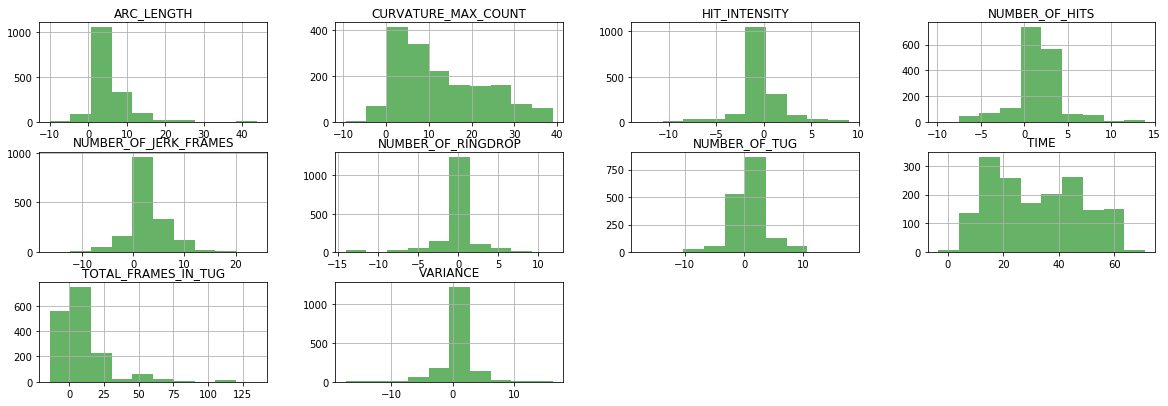

In [80]:
dataset["Hand-eye Coordination"][0].hist(color='g', alpha=0.6, bins=10, layout=(4,4), figsize=(20,9))

In [81]:
target.columns

Index(['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

# Noisy label Sampling

In [82]:
STD = 0.5 #hyperparameter

cols = ['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Overall']
for l_idx in cols:
    trainx = dataset[l_idx][0]
    trainy = dataset[l_idx][1]
    for idx in trainy.index:
        
        label_val = Y_train.loc[idx][l_idx]
        sample = np.random.normal(0, 1) #sample from N(0,1)
        trainy.loc[idx+"_noisy"] = sample*STD+label_val
        trainx.loc[idx+"_noisy"] = X_train.loc[idx]

In [83]:
dataset["Hand-eye Coordination"][0]

NUMBER_OF_HITS  HIT_INTENSITY  \
VIDEO                                                                       
E4_t9_aug_noise_pertub_X,perturb_Y               -4.880151       0.027837   
E1_t6_aug_noise_perturb_Y                        12.135445       6.388418   
E4_t12_aug_noise_standard_normalize               0.139704       5.756851   
E5_t1_aug_noise_norm_l1                           3.495123      -0.803074   
T3_2_t3_aug_norm_l2                               0.000000       0.000000   
T1_1_t11_aug_pertub_X,perturb_Y                   1.000000       0.000000   
E5_t1_aug_norm_l1                                 0.000000       0.000000   
T3_2_t7_aug_perturb_Y                             1.000000       0.000000   
E1_t2                                             0.000000       0.000000   
E5_t4                                             2.000000       0.000000   
T3_2_t12_aug_add_constant_X                       2.000000       0.000000   
T1_1_t11                                          1.000000       0.000000   
T3_2_t1_aug_noise_add_constant_Y                  1.188796      -2.310238   
E2_t7_aug_add_constant_Y                          2.000000       0.000000   
E2_t12_aug_pertub_X,perturb_Y                     0.000000       0.000000   
E2_t7_aug_noise_add_constant_Y                   11.223564      -5.563174   
T3_2_t3_aug_add_constant_Y                        0.000000       0.000000   
E5_t1_aug_noise_perturb_X                         0.234130       0.255881   
E1_t5_aug_pertub_X,perturb_Y                      1.000000       0.000000   
E2_t7_aug_add_constant_Y                          2.000000       0.000000   
E4_t9_aug_norm_l2                                 2.000000       0.000000   
E2_t7_aug_noise_add_constant_Y                   11.223564      -5.563174   
T3_2_t6_aug_add_constant_X                        3.000000       0.000000   
E4_t9                                             2.000000       0.000000   
E1_t4_aug_noise_replace_X,Y                       1.315009       4.839655   
T3_2_t4_aug_perturb_Y                             0.000000       0.000000   
E2_t12_aug_standard_normalize                     0.000000       0.000000   
T3_2_t10_aug_pertub_X,perturb_Y                   3.000000       0.000000   
E4_t12_aug_noise_pertub_X,perturb_Y               3.066315      -1.909726   
T1_1_t11_aug_add_constant_Y                       1.000000       0.000000   
...                                                    ...            ...   
T1_1_t5_aug_perturb_X_noisy                       0.000000       0.000000   
T1_1_t7_aug_noise_add_constant_Y_noisy            6.305122      -0.247866   
T1_1_t6_aug_pertub_X,perturb_Y_noisy              4.000000       0.000000   
T1_1_t5_aug_noise_replace_X,Y_noisy              -2.633963       0.539315   
T1_1_t6_aug_noise_perturb_X_noisy                -1.369605       0.958308   
T1_1_t7_noisy                                     2.000000       0.000000   
T1_1_t8_aug_noise_replace_X,Y_noisy               3.696644       2.540641   
T1_1_t9_aug_replace_X,Y_noisy                     1.000000       0.000000   
T1_1_t8_noisy                                     0.000000       0.000000   
T1_1_t6_aug_noise_pertub_X,perturb_Y_noisy        1.239416      -7.010559   
T1_1_t8_aug_noise_norm_l1_noisy                   7.872606       0.982960   
T1_1_t8_aug_noise_add_constant_Y_noisy           -2.071052       0.454530   
T1_1_t5_aug_standard_normalize_noisy              0.000000       0.000000   
T1_1_t6_noisy                                     4.000000       0.000000   
T1_1_t7_aug_standard_normalize_noisy              2.000000       0.000000   
T1_1_t8_aug_noise_perturb_X_noisy                 0.607343       2.307348   
T1_1_t8_aug_replace_X,Y_noisy                     0.000000       0.000000   
T1_1_t5_aug_noise_perturb_X_noisy                 2.494526       1.116621   
T1_1_t8_aug_standard_normalize_noisy              0.000000       0.000000   
T1_1_t9_noisy                           

In [84]:
dataset["Hand-eye Coordination"][1]

TARGET
VIDEO                                               
E4_t9_aug_noise_pertub_X,perturb_Y          3.000000
E1_t6_aug_noise_perturb_Y                   3.000000
E4_t12_aug_noise_standard_normalize         3.000000
E5_t1_aug_noise_norm_l1                     3.000000
T3_2_t3_aug_norm_l2                         3.000000
T1_1_t11_aug_pertub_X,perturb_Y             3.000000
E5_t1_aug_norm_l1                           3.000000
T3_2_t7_aug_perturb_Y                       3.000000
E1_t2                                       3.000000
E5_t4                                       3.000000
T3_2_t12_aug_add_constant_X                 3.000000
T1_1_t11                                    3.000000
T3_2_t1_aug_noise_add_constant_Y            3.000000
E2_t7_aug_add_constant_Y                    3.000000
E2_t12_aug_pertub_X,perturb_Y               3.000000
E2_t7_aug_noise_add_constant_Y              3.000000
T3_2_t3_aug_add_constant_Y                  3.000000
E5_t1_aug_noise_perturb_X                   3.000000
E1_t5_aug_pertub_X,perturb_Y                3.000000
E2_t7_aug_add_constant_Y                    3.000000
E4_t9_aug_norm_l2                           3.000000
E2_t7_aug_noise_add_constant_Y              3.000000
T3_2_t6_aug_add_constant_X                  3.000000
E4_t9                                       3.000000
E1_t4_aug_noise_replace_X,Y                 3.000000
T3_2_t4_aug_perturb_Y                       3.000000
E2_t12_aug_standard_normalize               3.000000
T3_2_t10_aug_pertub_X,perturb_Y             3.000000
E4_t12_aug_noise_pertub_X,perturb_Y         3.000000
T1_1_t11_aug_add_constant_Y                 3.000000
...                                              ...
T1_1_t5_aug_perturb_X_noisy                 0.909355
T1_1_t7_aug_noise_add_constant_Y_noisy      0.947687
T1_1_t6_aug_pertub_X,perturb_Y_noisy        0.908443
T1_1_t5_aug_noise_replace_X,Y_noisy         2.296056
T1_1_t6_aug_noise_perturb_X_noisy           0.773965
T1_1_t7_noisy                               1.036656
T1_1_t8_aug_noise_replace_X,Y_noisy         0.690961
T1_1_t9_aug_replace_X,Y_noisy               0.175580
T1_1_t8_noisy                               0.972968
T1_1_t6_aug_noise_pertub_X,perturb_Y_noisy  1.840301
T1_1_t8_aug_noise_norm_l1_noisy             0.991495
T1_1_t8_aug_noise_add_constant_Y_noisy      1.061809
T1_1_t5_aug_standard_normalize_noisy        2.193270
T1_1_t6_noisy                               1.287799
T1_1_t7_aug_standard_normalize_noisy        0.758113
T1_1_t8_aug_noise_perturb_X_noisy           0.623389
T1_1_t8_aug_replace_X,Y_noisy               0.423250
T1_1_t5_aug_noise_perturb_X_noisy           0.931200
T1_1_t8_aug_standard_normalize_noisy        0.924473
T1_1_t9_noisy                               1.092939
T1_1_t7_aug_replace_X,Y_noisy               1.161610
T1_1_t9_aug_pertub_X,perturb_Y_noisy        0.482398
T1_1_t8_aug_add_constant_Y_noisy            1.371951
T1_1_t9_aug_noise_norm_l1_noisy             0.019243
T1_1_t5_aug_noise_add_constant_X_noisy      0.654730
T1_1_t7_aug_noise_pertub_X,perturb_Y_noisy  1.463982
T1_1_t7_aug_pertub_X,perturb_Y_noisy        0.752710
T1_1_t9_aug_noise_replace_X,Y_noisy         1.587926
T1_1_t8_aug_noise_pertub_X,perturb_Y_noisy  1.994182
T1_1_t5_aug_norm_l1_noisy                   1.017520

[2462 rows x 1 columns]

In [85]:
# labels_gt

In [86]:
# labels_gt[0].value_counts()

In [87]:
X_test

NUMBER_OF_HITS  HIT_INTENSITY  NUMBER_OF_TUG  TOTAL_FRAMES_IN_TUG  \
VIDEO                                                                         
E6_t1                3.0            0.0            1.0                  2.0   
E6_t2                3.0            0.0            3.0                 58.0   
E6_t3                0.0            0.0            2.0                  3.0   
E6_t4                3.0            0.0            0.0                  0.0   
E6_t5                0.0            0.0            0.0                  0.0   
E6_t6                1.0            0.0            0.0                  0.0   
E6_t7                3.0            0.0            8.0                 13.0   
E6_t8                2.0            1.0           20.0                 33.0   
E6_t9                1.0            0.0            6.0                 34.0   
E6_t10               1.0            0.0            8.0                 12.0   
E6_t11               3.0            0.0            3.0                 44.0   
E6_t12               1.0            0.0            3.0                  6.0   
T8_1_t1              1.0            0.0            0.0                  0.0   
T8_1_t2              2.0            0.0            1.0                 21.0   
T8_1_t3              0.0            0.0            0.0                  0.0   
T8_1_t4              3.0            0.0            1.0                 17.0   
T8_1_t5              0.0            0.0            0.0                  0.0   
T8_1_t6              2.0            0.0            0.0                  0.0   
T8_1_t7              1.0            0.0            0.0                  0.0   
T8_1_t8              0.0            0.0            0.0                  0.0   
T8_1_t9              0.0            0.0            0.0                  0.0   
T8_1_t10             2.0            0.0            1.0                  4.0   
T8_1_t11             0.0            0.0            0.0                  0.0   
T8_1_t12             1.0            0.0            1.0                 23.0   

          NUMBER_OF_JERK_FRAMES   TIME  NUMBER_OF_RINGDROP  VARIANCE  \
VIDEO                                                                  
E6_t1                       0.0  29.00                 0.0  0.028333   
E6_t2                       3.0  30.00                 0.0  0.028916   
E6_t3                       0.0  21.72                 0.0  0.038643   
E6_t4                       6.0  30.60                 0.0  0.043718   
E6_t5                       1.0  24.84                 0.0  0.038487   
E6_t6                       1.0  22.84                 0.0  0.042202   
E6_t7                       9.0  37.76                 0.0  0.032234   
E6_t8                       3.0  30.84                 0.0  0.027167   
E6_t9                       0.0  28.84                 0.0  0.039825   
E6_t10                      0.0  25.00                 0.0  0.041824   
E6_t11                      1.0  28.56                 0.0  0.040181   
E6_t12                      1.0  28.76                 0.0  0.039875   
T8_1_t1                     1.0  42.00                 0.0  0.025030   
T8_1_t2                     0.0  53.76                 0.0  0.061870   
T8_1_t3                     0.0  29.00                 0.0  0.067421   
T8_1_t4                     3.0  32.72                 0.0  0.035629   
T8_1_t5                     3.0  26.60                 0.0  0.050109   
T8_1_t6                     0.0  27.72                 0.0  0.046199   
T8_1_t7                     8.0  22.84                 0.0  0.029021   
T8_1_t8                     0.0  25.84                 0.0  0.037335   
T8_1_t9                     4.0  22.84                 0.0  0.040169   
T8_1_t10                    0.0  23.84                 0.0  0.029878   
T8_1_t11                    2.0  25.84                 0.0  0.036832   
T8_1_t12                    2.0  29.92                 0.0  0.039068   

          ARC_LENGTH  CURVATURE_MAX_COUNT  
VIDEO                                 

In [88]:
# normalized_data_gt

2 approaches k fold : mean and std (Stability) or Val set find best hypermeters : Grid search

In [42]:
corMatrix_gt = pd.DataFrame.corr(X_train)

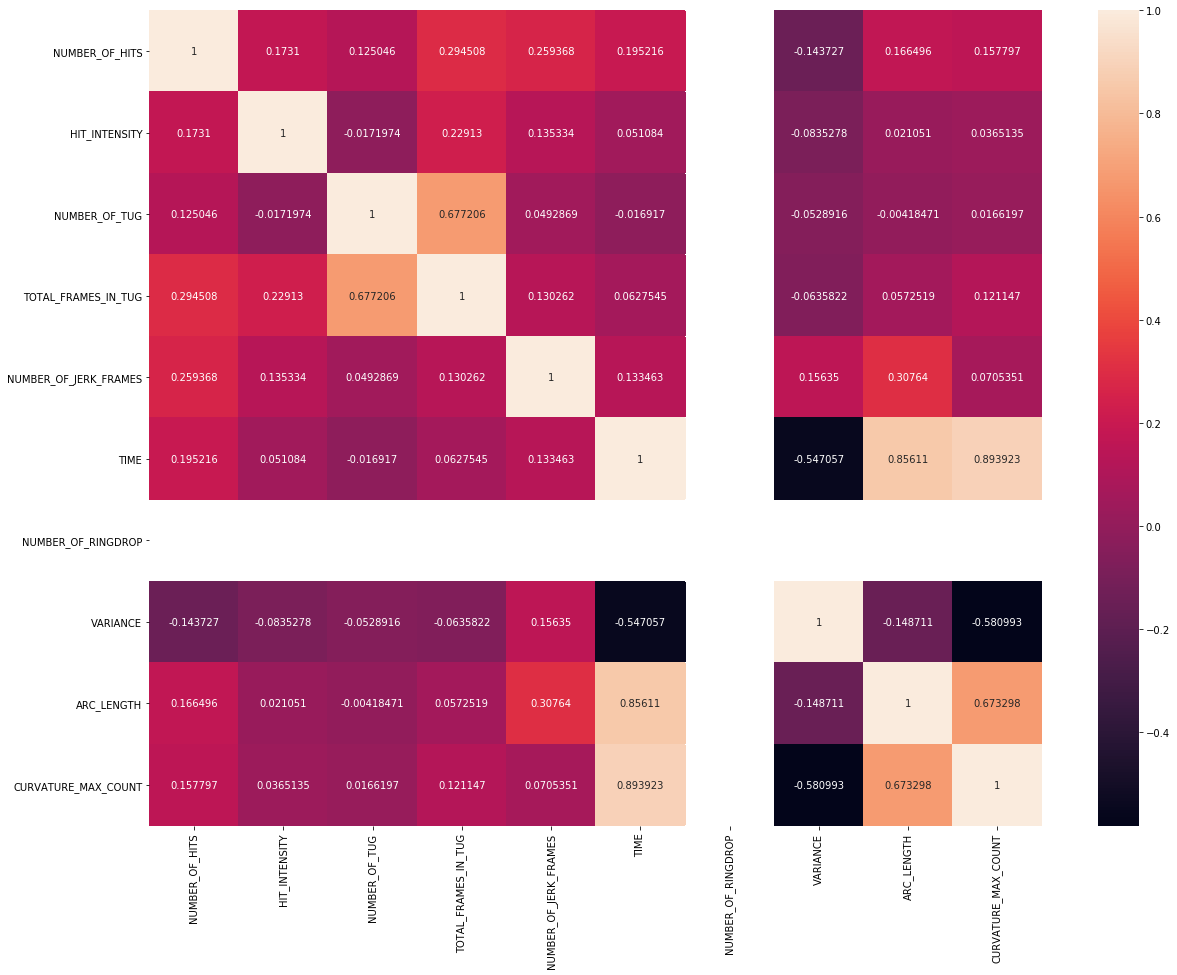

In [43]:
f, ax = plt.subplots(figsize=(20, 15))

ax = sn.heatmap(corMatrix_gt, annot=True, fmt='g')
plt.show()

# COVARIANCE

In [39]:
covarianceMatrix_gt = pd.DataFrame.cov(X_train)

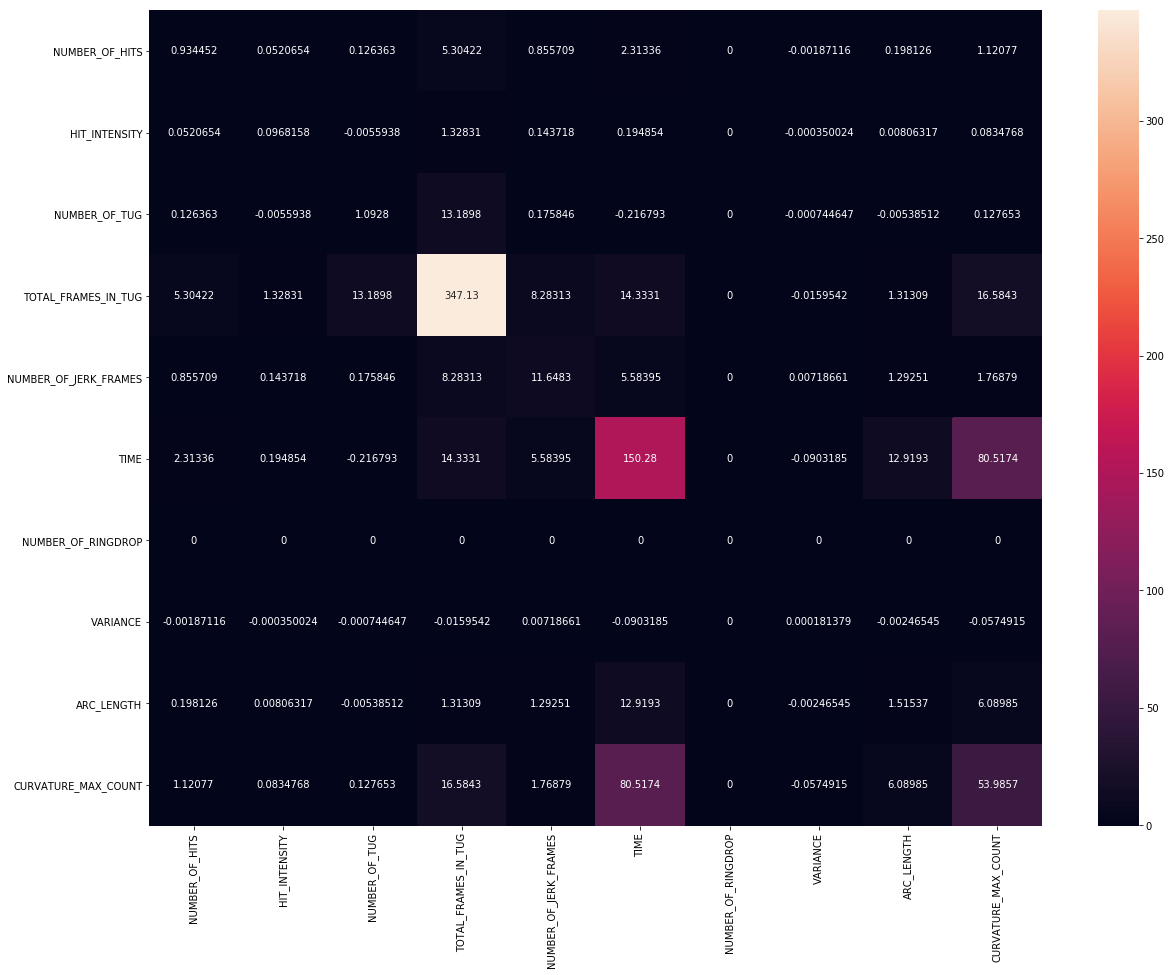

In [40]:
f, ax = plt.subplots(figsize=(20, 15))

ax = sn.heatmap(covarianceMatrix_gt, annot=True,fmt='g')
plt.show()

In [41]:
corr = data_gt.corr().abs()

s = corr.unstack()
sorted_values = s.sort_values(kind="quicksort")
df = sorted_values[sorted_values<1.0][::-1][::2].to_frame()
df

0
TIME                  CURVATURE_MAX_COUNT    0.885807
ARC_LENGTH            TIME                   0.835636
                      CURVATURE_MAX_COUNT    0.653348
CURVATURE_MAX_COUNT   VARIANCE               0.491017
VARIANCE              TIME                   0.489202
NUMBER_OF_TUG         TOTAL_FRAMES_IN_TUG    0.421663
NUMBER_OF_HITS        TOTAL_FRAMES_IN_TUG    0.339029
                      NUMBER_OF_JERK_FRAMES  0.257148
NUMBER_OF_JERK_FRAMES ARC_LENGTH             0.241502
HIT_INTENSITY         TOTAL_FRAMES_IN_TUG    0.233274
TIME                  NUMBER_OF_HITS         0.218737
HIT_INTENSITY         NUMBER_OF_TUG          0.209093
CURVATURE_MAX_COUNT   NUMBER_OF_HITS         0.188725
VARIANCE              NUMBER_OF_HITS         0.172409
NUMBER_OF_TUG         NUMBER_OF_HITS         0.168649
NUMBER_OF_HITS        ARC_LENGTH             0.164326
NUMBER_OF_TUG         VARIANCE               0.158542
HIT_INTENSITY         NUMBER_OF_HITS         0.154065
TOTAL_FRAMES_IN_TUG   CURVATURE_MAX_COUNT    0.140888
HIT_INTENSITY         NUMBER_OF_JERK_FRAMES  0.129858
TIME                  NUMBER_OF_JERK_FRAMES  0.114206
TOTAL_FRAMES_IN_TUG   NUMBER_OF_JERK_FRAMES  0.109354
VARIANCE              NUMBER_OF_JERK_FRAMES  0.097542
TIME                  NUMBER_OF_TUG          0.085344
TOTAL_FRAMES_IN_TUG   TIME                   0.084767
HIT_INTENSITY         VARIANCE               0.084226
TOTAL_FRAMES_IN_TUG   VARIANCE               0.079725
ARC_LENGTH            TOTAL_FRAMES_IN_TUG    0.065342
NUMBER_OF_TUG         CURVATURE_MAX_COUNT    0.063192
VARIANCE              ARC_LENGTH             0.058525
NUMBER_OF_TUG         NUMBER_OF_JERK_FRAMES  0.058222
CURVATURE_MAX_COUNT   NUMBER_OF_JERK_FRAMES  0.038930
NUMBER_OF_TUG         ARC_LENGTH             0.037864
HIT_INTENSITY         ARC_LENGTH             0.025048
                      TIME                   0.024785
CURVATURE_MAX_COUNT   HIT_INTENSITY          0.010034

# LEARNING BASED APPROACHES

In [94]:
from sklearn import svm
from sklearn import linear_model 
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import classification_report
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.pipeline import make_pipeline

In [95]:
Y_train.columns

Index(['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

In [144]:
# X, Y = dataset["Hand-eye Coordination"][0], dataset["Hand-eye Coordination"][1]

In [145]:
# X= X.reset_index()
# Y= Y.reset_index()
# X = X.drop(["VIDEO"], axis = 1)
# Y = Y.drop(["VIDEO"], axis = 1)
# idx = np.random.permutation(X.index)
# X= X.reindex(idx)
# Y= Y.reindex(idx)


In [104]:
Y_train.columns

Index(['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

In [197]:
parameter='Hand-eye Coordination'

In [198]:
X = X_train
Y = pd.DataFrame(Y_train[parameter])

In [199]:
# X

In [200]:
# Y

In [194]:
# X=X.append(X_test.tail())
# X=X.append(X_test.head())


In [195]:
# Y_H=Y_test.head()
# Y_T=Y_test.tail()

In [196]:
# Y=Y.append(pd.DataFrame(Y_H[parameter]))
# Y=Y.append(pd.DataFrame(Y_T[parameter]))


In [201]:
# normalized_data_gt=(data_gt-data_gt.min())/(data_gt.max()-data_gt.min())
#regressor = svm.SVR(kernel='rbf', epsilon=1)
# regressor = svm.NuSVR(kernel='rbf', nu=0.7)
# regressor = linear_model.SGDRegressor(max_iter=100000, tol=1e-3,verbose=1)
# regressor = make_pipeline(preprocessing.StandardScaler(),linear_model.SGDRegressor(alpha=0.0000001,max_iter=10000, tol=1e-3,verbose=1,penalty= 'elasticnet'))
regressor = RandomForestRegressor()
#regressor = DecisionTreeRegressor()

regressor.fit(X, Y)
print("r^2 Score", regressor.score(X, Y)) #r^2 for svm

Y_pred_train = regressor.predict(X)
print("Training MSE", mean_squared_error(Y_pred_train, Y))
print("Traning Correlation : ",pearsonr(Y_pred_train,Y.values.ravel())[0])

#print("Training Correlation : ",pearsonr(Y_pred_train, Y)[0])

Y_pred = regressor.predict(X_test)

print("Testing MSE : ",mean_squared_error(Y_pred, Y_test[parameter]))

print("Testing Correlation : ",pearsonr(Y_pred,Y_test[parameter])[0])


Y_pred_truncated = [round(x) for x in Y_pred] #rounding to nearest integer

for x,y,z in zip(Y_pred, Y_pred_truncated,Y_test[parameter]):
    print(x," ", y, " ", z)

print("MSE test truncated : ",mean_squared_error(Y_pred_truncated,  Y_test[parameter]))

Y_pred_train_truncated = [round(x) for x in Y_pred_train] #rounding to nearest integer
print("MSE train truncated : ",mean_squared_error(Y_pred_train_truncated,  Y))

print("Accuracy test : ", accuracy_score(Y_pred_truncated, Y_test[parameter]))

print("Accuracy train : ", accuracy_score(Y_pred_train_truncated, Y))

from sklearn.metrics import f1_score

print("F1-score-Macro_test: ", f1_score(Y_test[parameter], Y_pred_truncated, average='macro'))

print("F1-score-Macro_train: ", f1_score(Y, Y_pred_train_truncated, average='macro'))

print("F1-score-Micro_test: ", f1_score(Y_test[parameter], Y_pred_truncated, average='micro'))

print("F1-score-Micro_train: ", f1_score(Y, Y_pred_train_truncated, average='micro'))

print("F1-score-weighted_test: ", f1_score(Y_test[parameter], Y_pred_truncated, average='weighted'))

print("F1-score-weighted_train: ", f1_score(Y, Y_pred_train_truncated, average='weighted'))

print("F1-score-none_test: ", f1_score(Y_test[parameter], Y_pred_truncated, average=None))

print("F1-score-none_train: ", f1_score(Y, Y_pred_train_truncated, average=None))

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


r^2 Score 0.9299893088552916
Training MSE 0.04489605263157894
Traning Correlation :  0.9708118423515035
Testing MSE :  0.43903333333333333
Testing Correlation :  0.6244427664808845
2.08   2.0   1
3.46   3.0   4
2.23   2.0   2
1.87   2.0   2
3.09   3.0   2
3.36   3.0   3
3.18   3.0   3
2.99   3.0   3
2.3   2.0   2
3.46   3.0   4
2.09   2.0   2
3.07   3.0   3
3.39   3.0   3
3.56   4.0   3
3.76   4.0   4
1.95   2.0   4
3.36   3.0   4
3.78   4.0   3
3.79   4.0   4
3.56   4.0   3
3.33   3.0   4
3.39   3.0   3
3.36   3.0   4
3.39   3.0   3
MSE test truncated :  0.5833333333333334
MSE train truncated :  0.02631578947368421
Accuracy test :  0.5416666666666666
Accuracy train :  0.9736842105263158
F1-score-Macro_test:  0.41091517178473697
F1-score-Macro_train:  0.9188877043354655
F1-score-Micro_test:  0.5416666666666666
F1-score-Micro_train:  0.9736842105263158
F1-score-weighted_test:  0.5077024424850511
F1-score-weighted_train:  0.9748391501140911
F1-score-none_test:  [0.         0.72727273 0.6

In [189]:
regressor.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [134]:
from sklearn.decomposition import PCA

pca = PCA(2) # EXPLAINATION ?
X_train_vis = pca.fit_transform(X_test[['NUMBER_OF_HITS', 'HIT_INTENSITY']])
X_test_vis = pca.transform(X_test[['NUMBER_OF_HITS', 'HIT_INTENSITY']])

In [135]:
X_test[['NUMBER_OF_HITS', 'HIT_INTENSITY']]

NUMBER_OF_HITS  HIT_INTENSITY
VIDEO                                  
E6_t1                3.0            0.0
E6_t2                3.0            0.0
E6_t3                0.0            0.0
E6_t4                3.0            0.0
E6_t5                0.0            0.0
E6_t6                1.0            0.0
E6_t7                3.0            0.0
E6_t8                2.0            1.0
E6_t9                1.0            0.0
E6_t10               1.0            0.0
E6_t11               3.0            0.0
E6_t12               1.0            0.0
T8_1_t1              1.0            0.0
T8_1_t2              2.0            0.0
T8_1_t3              0.0            0.0
T8_1_t4              3.0            0.0
T8_1_t5              0.0            0.0
T8_1_t6              2.0            0.0
T8_1_t7              1.0            0.0
T8_1_t8              0.0            0.0
T8_1_t9              0.0            0.0
T8_1_t10             2.0            0.0
T8_1_t11             0.0            0.0
T8_1_t12             1.0            0.0

In [128]:
labels_gt.columns

Index(['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

ValueError: c of shape (24,) not acceptable as a color sequence for x with size 2462, y with size 2462

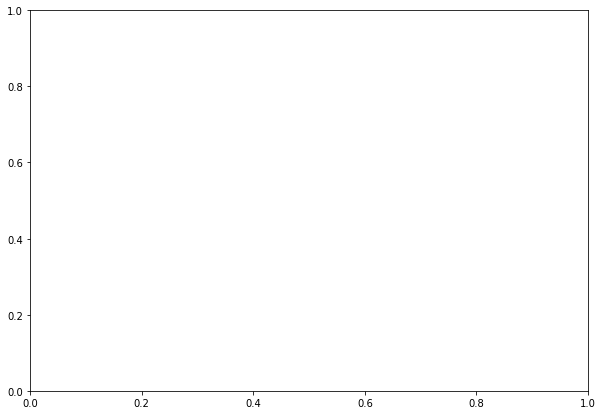

In [150]:
"""################### PCA 3d PLOT ##############################################"""

from mpl_toolkits import mplot3d 

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

fig = plt.figure(figsize = (10, 7)) 
# ax = plt.axes(projection ="3d") 

plt.scatter(X[['NUMBER_OF_HITS']], X[['HIT_INTENSITY']],  c=Y_test['Hand-eye Coordination'])

    # plot data
# ax.scatter3D(X_train_vis[:, 0], X_train_vis[:, 1],X_train_vis[:, 2], alpha=0.8, c=Y_test['Instrument-Tissue Manipulation'])
# for length, vector in zip(pca.explained_variance_, pca.components_):
#     v = vector * 3 * np.sqrt(length)
#     #draw_vector(pca.mean_, pca.mean_ + v)
# plt.axis('equal');


# Scaled

In [190]:
# normalized_data_gt=(data_gt-data_gt.min())/(data_gt.max()-data_gt.min())
regressor = svm.SVC()
def std_scaling(df):
#     scaler = preprocessing.StandardScaler()

    index = df.index
    # Get column names first
    names = df.columns
    # Create the Scaler object
    
    # Fit your data on the scaler object
    scaled_df = scale(df)
    normalized_data_gt = pd.DataFrame(scaled_df, columns=names, index= index)
    return normalized_data_gt

# regressor.fit(std_scaling(X), Y)
# Y_pred = regressor.predict(std_scaling(X_test))
# print("MSE : ",mean_squared_error(Y_pred,  pd.DataFrame(Y_test['Hand-eye Coordination'])))

# Y_pred_truncated = [round(x) for x in Y_pred] #rounding to nearest integer
# print("MSE truncated : ",mean_squared_error(Y_pred_truncated,  Y_test['Hand-eye Coordination']))

# print("Accuracy : ", accuracy_score(Y_pred_truncated, Y_test['Hand-eye Coordination']))

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MSE :  0.3745876058061726
MSE truncated :  0.5416666666666666
Accuracy :  0.5833333333333334


# Upsampled

In [202]:
# normalized_data_gt=(data_gt-data_gt.min())/(data_gt.max()-data_gt.min())
# regressor = svm.NuSVR()
# regressor = make_pipeline(preprocessing.StandardScaler(),linear_model.SGDRegressor(alpha=0.0000001,max_iter=10000, tol=1e-3,verbose=1,penalty= 'elasticnet'))

regressors = [
    KNeighborsRegressor(5),   
    #svm.SVR(),
    #svm.NuSVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor() 
]

params_regressors = [
    {"n_neighbors":[3,4,5], "algorithm" :["auto", "ball_tree", "kd_tree", "brute"]},
    #{'kernel': ['linear', 'rbf'],'C': [1, 10]}, #svc
    #{'kernel': ['linear', 'rbf'], 'C': [ 1, 10], 'nu':[0.3,0.5,0.7,0.9]}, #linear kernel svc
    {"max_depth": [4,5,6,7,8],"splitter":["best", "random"]}, #decision tree
    {"max_depth":[4,5,6,7,8], "n_estimators":[10,20], "max_features":[1,2,5]}, #Random forest
]


X_upsampled_train, Y_upsampled_train = X, Y #dataset['Hand-eye Coordination']

results = []
for i in range(len(regressors)):
    res={}
    clf = GridSearchCV(regressors[i], params_regressors[i],scoring=make_scorer(mean_squared_error), cv=5)
                                                        #make_scorer(label_ranking_loss)
    clf.fit(X_upsampled_train, Y_upsampled_train.values.ravel())

    Y_pred = clf.predict(X_test) #y_pred
#     Y_pred = [round(x) for x in Y_pred] #rounding to nearest integer

    r = pearsonr(Y_pred, Y_test['Hand-eye Coordination'].values.ravel())

    res["estimator"] = clf.best_estimator_
    res["Estimatior_Type"] = params_regressors[i].__class__.__name__ #res["parameter_search_dict"] = clf.best_params_
    res["Testing_MSE"] = mean_squared_error(Y_pred, Y_test['Hand-eye Coordination'].values.ravel()) #ypred vs gt y for test data
    res["Testing_Correlation"] = r[0]
    res["Training_MSE"] = clf.best_score_
                 
    print(res)
    results.append(res)
                
# regressor.fit(X_upsampled_train, Y_upsampled_train)
# Y_pred = regressor.predict(X_test)
# print("MSE : ",mean_squared_error(Y_pred,  Y_test['Hand-eye Coordination']))
# print("Correlation : ",pearsonr(Y_pred,Y_test['Hand-eye Coordination'])[0])


# Y_pred_truncated = [round(x) for x in Y_pred] #rounding to nearest integer
# print("MSE truncated : ",mean_squared_error(Y_pred_truncated,  Y_test['Hand-eye Coordination']))

# print("Accuracy : ", accuracy_score(Y_pred_truncated, Y_test['Hand-eye Coordination']))


{'estimator': KNeighborsRegressor(), 'Estimatior_Type': 'dict', 'Testing_MSE': 0.49833333333333335, 'Testing_Correlation': 0.5708145393463959, 'Training_MSE': 0.4087666666666667}
{'estimator': DecisionTreeRegressor(max_depth=7, splitter='random'), 'Estimatior_Type': 'dict', 'Testing_MSE': 0.577277970011534, 'Testing_Correlation': 0.6112174582010449, 'Training_MSE': 0.6791544656271288}
{'estimator': RandomForestRegressor(max_depth=4, max_features=1, n_estimators=10), 'Estimatior_Type': 'dict', 'Testing_MSE': 0.4258387880262233, 'Testing_Correlation': 0.6634004421048395, 'Training_MSE': 0.3914351805307366}


In [203]:
pd.DataFrame(results)

Estimatior_Type  Testing_Correlation  Testing_MSE  Training_MSE  \
0            dict             0.570815     0.498333      0.408767   
1            dict             0.611217     0.577278      0.679154   
2            dict             0.663400     0.425839      0.391435   

                                           estimator  
0                              KNeighborsRegressor()  
1  DecisionTreeRegressor(max_depth=7, splitter='r...  
2  (DecisionTreeRegressor(max_depth=4, max_featur...

In [71]:
labels_gt.columns

Index(['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity',
       'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

In [254]:
# normalized_data_gt=(data_gt-data_gt.min())/(data_gt.max()-data_gt.min())
# regressor = svm.NuSVR()
# regressor = make_pipeline(preprocessing.StandardScaler(),linear_model.SGDRegressor(alpha=0.0000001,max_iter=10000, tol=1e-3,verbose=1,penalty= 'elasticnet'))

regressors = [
    KNeighborsRegressor(5),   
    svm.SVR(),
    svm.NuSVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor() 
]

params_regressors = [
    {"n_neighbors":[3,4,5], "algorithm" :["auto", "ball_tree", "kd_tree", "brute"]},
    {'kernel': ['linear', 'rbf'],'C': [1, 10]}, #svc
    {'kernel': ['linear', 'rbf'], 'C': [ 1, 10], 'nu':[0.3,0.5,0.7,0.9]}, #linear kernel svc
    {"max_depth": [4,5,6,7,8],"splitter":["best", "random"]}, #decision tree
    {"max_depth":[4,5,6,7,8], "n_estimators":[10,20], "max_features":[1,2,5]}, #Random forest
]


X_upsampled_train, Y_upsampled_train = dataset['Instrument-Tissue Manipulation']

results_ITM = []
for i in range(len(regressors)):
    res={}
    clf = GridSearchCV(regressors[i], params_regressors[i],scoring=make_scorer(mean_squared_error), cv=5)
                                                        #make_scorer(label_ranking_loss)
    clf.fit(X_upsampled_train, Y_upsampled_train.values.ravel())

    Y_pred = clf.predict(X_test) #y_pred
#     Y_pred = [round(x) for x in Y_pred] #rounding to nearest integer

    r = pearsonr(Y_pred, Y_test['Instrument-Tissue Manipulation'].values.ravel())

    res["estimator"] = clf.best_estimator_
    res["Estimatior_Type"] = params_regressors[i].__class__.__name__ #res["parameter_search_dict"] = clf.best_params_
    res["Testing_MSE"] = mean_squared_error(Y_pred, Y_test['Instrument-Tissue Manipulation'].values.ravel()) #ypred vs gt y for test data
    res["Testing_Correlation"] = r[0]
    res["Training_MSE"] = clf.best_score_
                 
    print(res)
    results_ITM.append(res)
                
# regressor.fit(X_upsampled_train, Y_upsampled_train)
# Y_pred = regressor.predict(X_test)
# print("MSE : ",mean_squared_error(Y_pred,  Y_test['Hand-eye Coordination']))
# print("Correlation : ",pearsonr(Y_pred,Y_test['Hand-eye Coordination'])[0])


# Y_pred_truncated = [round(x) for x in Y_pred] #rounding to nearest integer
# print("MSE truncated : ",mean_squared_error(Y_pred_truncated,  Y_test['Hand-eye Coordination']))

# print("Accuracy : ", accuracy_score(Y_pred_truncated, Y_test['Hand-eye Coordination']))


{'estimator': KNeighborsRegressor(), 'Estimatior_Type': 'dict', 'Testing_MSE': 0.40833333333333327, 'Testing_Correlation': 0.3936481072421527, 'Training_MSE': 0.5825968253968254}
{'estimator': SVR(C=10, kernel='linear'), 'Estimatior_Type': 'dict', 'Testing_MSE': 1.757976419171363, 'Testing_Correlation': 0.04967808171886469, 'Training_MSE': 1.5326455221120525}
{'estimator': NuSVR(C=10, kernel='linear'), 'Estimatior_Type': 'dict', 'Testing_MSE': 0.852604413188852, 'Testing_Correlation': 0.18085965336855195, 'Training_MSE': 1.6135025198263366}
{'estimator': DecisionTreeRegressor(max_depth=4, splitter='random'), 'Estimatior_Type': 'dict', 'Testing_MSE': 1.10158457424619, 'Testing_Correlation': 0.051108793436323456, 'Training_MSE': 0.746316421198183}
{'estimator': RandomForestRegressor(max_depth=5, max_features=1, n_estimators=10), 'Estimatior_Type': 'dict', 'Testing_MSE': 0.25442658731530116, 'Testing_Correlation': 0.47507655648171393, 'Training_MSE': 0.6436952622625806}


In [255]:
results_ITM

[{'estimator': KNeighborsRegressor(),
  'Estimatior_Type': 'dict',
  'Testing_MSE': 0.40833333333333327,
  'Testing_Correlation': 0.3936481072421527,
  'Training_MSE': 0.5825968253968254},
 {'estimator': SVR(C=10, kernel='linear'),
  'Estimatior_Type': 'dict',
  'Testing_MSE': 1.757976419171363,
  'Testing_Correlation': 0.04967808171886469,
  'Training_MSE': 1.5326455221120525},
 {'estimator': NuSVR(C=10, kernel='linear'),
  'Estimatior_Type': 'dict',
  'Testing_MSE': 0.852604413188852,
  'Testing_Correlation': 0.18085965336855195,
  'Training_MSE': 1.6135025198263366},
 {'estimator': DecisionTreeRegressor(max_depth=4, splitter='random'),
  'Estimatior_Type': 'dict',
  'Testing_MSE': 1.10158457424619,
  'Testing_Correlation': 0.051108793436323456,
  'Training_MSE': 0.746316421198183},
 {'estimator': RandomForestRegressor(max_depth=5, max_features=1, n_estimators=10),
  'Estimatior_Type': 'dict',
  'Testing_MSE': 0.25442658731530116,
  'Testing_Correlation': 0.47507655648171393,
  'Trai

In [28]:
regressor.fit_status_

0

In [ ]:
from sklearn.neural_network import MLPRegressor
X_upsampled_train, Y_upsampled_train = dataset['Hand-eye Coordination']

mlp = MLPRegressor(max_iter=5000)

parameter_space = {
    'hidden_layer_sizes': [(64,32,16,8,4), (20), (100,10,100,10)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_upsampled_train,Y_upsampled_train)

Y_train_pred = clf.predict(X_upsampled_train)
Y_pred = clf.predict(X_test)

In [ ]:
clf.best_estimator_

In [ ]:
clf.get_params(deep=True)

In [ ]:
print(mean_squared_error(Y_train_pred, Y_upsampled_train.values.ravel())) #ypred vs gt y for test data

In [ ]:
# Y_pred = [round(x) for x in Y_pred]

In [ ]:
Y_test['Hand-eye Coordination']

In [ ]:
Y_pred

In [ ]:
print(mean_squared_error(Y_pred, Y_test['Hand-eye Coordination'].values.ravel())) #ypred vs gt y for test data


In [ ]:
clf.score(X_test,Y_test['Hand-eye Coordination'])

In [229]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1, l2

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=10, activation='relu', activity_regularizer=l1(0.0001), kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='relu', activity_regularizer=l1(0.0001), kernel_regularizer=l2(0.001)))
    model.add(Dense(1))
    # Compile model
    
#   opt = keras.optimizers.Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    model.compile(loss='mean_squared_error', optimizer="adam", metrics=['mae']) #
    return model
 
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [230]:
X_upsampled_train, Y_upsampled_train = dataset['Hand-eye Coordination']

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# create model
model = KerasClassifier(build_fn=create_model, epochs=1000, batch_size=4, verbose=1, callbacks=[es])
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
history = model.fit(std_scaling(X_upsampled_train), std_scaling(Y_upsampled_train), validation_split=0.2, shuffle=True)


# print(results.mean())

Train on 124 samples, validate on 32 samples
Epoch 1/1000
124/124 [==============================] - 6s 47ms/step - loss: 3.4742 - mean_absolute_error: 1.6520 - val_loss: 0.7983 - val_mean_absolute_error: 0.7655
Epoch 2/1000
124/124 [==============================] - 0s 1ms/step - loss: 2.2206 - mean_absolute_error: 1.2659 - val_loss: 0.5133 - val_mean_absolute_error: 0.6171
Epoch 3/1000
124/124 [==============================] - 0s 1ms/step - loss: 1.6562 - mean_absolute_error: 0.9979 - val_loss: 0.4748 - val_mean_absolute_error: 0.5204
Epoch 4/1000
124/124 [==============================] - 0s 1ms/step - loss: 1.2826 - mean_absolute_error: 0.8643 - val_loss: 0.5597 - val_mean_absolute_error: 0.5436
Epoch 00004: early stopping


dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


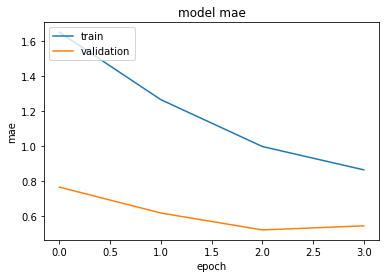

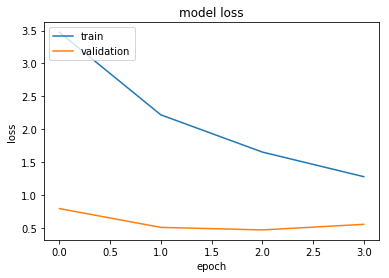

In [240]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [232]:
Y_pred = model.predict(std_scaling(X_test))

24/24 [==============================] - 2s 86ms/step


In [233]:
Y_pred

array([[-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ],
       [-1.34164079],
       [-0.4472136 ],
       [-0.4472136 ],
       [-1.34164079],
       [-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ],
       [-1.34164079],
       [-1.34164079],
       [-0.4472136 ],
       [-1.34164079],
       [-0.4472136 ],
       [-0.4472136 ],
       [-1.34164079],
       [-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ],
       [-0.4472136 ]])

In [234]:
scale(Y_test["Hand-eye Coordination"].values.ravel())

array([-0.06819943, -0.06819943,  1.56858698, -0.06819943,  1.56858698,
       -0.06819943, -0.06819943,  1.56858698, -0.06819943,  1.56858698,
       -0.06819943,  1.56858698, -1.70498585, -1.70498585, -1.70498585,
       -1.70498585, -0.06819943, -0.06819943, -0.06819943, -0.06819943,
       -0.06819943, -0.06819943, -0.06819943, -0.06819943])

In [235]:
mean_squared_error(Y_pred,scale(Y_test["Hand-eye Coordination"].values.ravel()))

1.203503717135228

In [236]:
pearsonr(Y_pred.flatten(),scale(Y_test["Hand-eye Coordination"].values.ravel()))[0]

0.5118745001228026

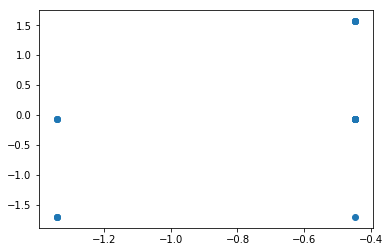

In [237]:
plt.scatter(Y_pred,scale(Y_test["Hand-eye Coordination"].values.ravel()))

In [302]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
 "Decision Tree", "Random Forest"] # "Neural Net", "Gaussian Process", "AdaBoost", "Naive Bayes", "QDA"]

ranking_classifiers =  [
    KNeighborsClassifier(),
#     LinearSVC( multi_class="crammer_singer"),
    DecisionTreeClassifier(),
    GaussianNB()
]

params_ranking_classifiers = [
    {"n_neighbors":[3,4,5], "algorithm" :["auto", "ball_tree", "kd_tree", "brute"]},
#     {'C': [0.025, 0.25, 1, 10, 100, 1000]}, #linear kernel svc
    {"max_depth": [4,5,6,7,8],"splitter":["best", "random"]}, #decision tree
]

classifiers = [
    KNeighborsClassifier(),
    SVC(), #gamma=2, C=1
    SVC(), #kernel="linear", C=0.025
    DecisionTreeClassifier(),
    RandomForestClassifier()]

params_classifiers = [
    {"n_neighbors":[3,4,5], "algorithm" :["auto", "ball_tree", "kd_tree", "brute"]},
    #{"n_neighbors":[3], "algorithm" :["auto"]},
    {'kernel': ['rbf'], 'gamma': [1,1e-1, 1e-2, 1e-3, 1e-4],'C': [1, 10, 100, 1000]}, #svc
    {'kernel': ['linear'], 'C': [0.025, 0.25, 1, 10, 100, 1000]}, #linear kernel svc
    {"max_depth": [4,5,6,7,8],"splitter":["best", "random"]}, #decision tree
    {"max_depth":[4,5,6,7,8], "n_estimators":[10,20], "max_features":[1,2,5]}, #Random forest
]

names_reg = [ "Nearest Neighbors Regressor", "Linear SVR Regressor", "RBF SVR",
         "Decision Tree Regressor", "Random Forest Regressor"]# "Neural Net Regressor",  "Gaussian Process Regressor", "AdaBoost Regressor"]


regressors = [
    KNeighborsRegressor(5),   
    SVR(),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor() 
]

params_regressors = [
    {"n_neighbors":[3,4,5], "algorithm" :["auto", "ball_tree", "kd_tree", "brute"]},
    {'kernel': ['rbf'], 'gamma': [1,1e-1, 1e-2, 1e-3, 1e-4],'C': [1, 10, 100, 1000]}, #svc
    {'kernel': ['linear'], 'C': [0.025, 0.25, 1, 10, 100, 1000]}, #linear kernel svc
    {"max_depth": [4,5,6,7,8],"splitter":["best", "random"]}, #decision tree
    {"max_depth":[4,5,6,7,8], "n_estimators":[10,20], "max_features":[1,2,5]}, #Random forest
]


In [307]:
class Trainer:
    
    def __init__(self, augmentations=False):
        self.aug = augmentations
          

    def run(self, X_train, Y_train, X_test, Y_test, classifiers, params, names, prediction_label = None, method = "classify", split_size = 0.20, k_folds = 5,digitize = False):
        
        results = []
        
        if  digitize: #for overall scores
            Y_train = np.digitize(np.array(Y_train),np.array([5.0, 10.0, 15.0, 20.0]))
       
        for parameters, model in zip(params, classifiers):
                print(prediction_label,model)
                res = {}
                if method == "classify":
                    clf = GridSearchCV(model, parameters, scoring="accuracy",cv=k_folds)
                                                        #make_scorer(label_ranking_loss)
                    clf.fit(X_train, Y_train.values.ravel())
                    
                    Y_pred = clf.predict(X_test) #y_pred
                   
                    print(classification_report(Y_pred, Y_test.values.ravel()))
                    r = pearsonr(Y_pred, Y_test.values.ravel())
                    
                    res["estimator"] = clf.best_estimator_
                    res["Estimatior_Type"] = model.__class__.__name__ #res["parameter_search_dict"] = clf.best_params_
                    res["Testing_Accuracy"] = accuracy_score(Y_pred, Y_test.values.ravel())
                    res["Testing_Correlation"] = r[0]
                    res["Training_Accuracy"] = clf.best_score_
                    
                    results.append(res)

                elif method == "regression":
                    clf = GridSearchCV(model, parameters,scoring=make_scorer(mean_squared_error), cv=k_folds)
                                                        #make_scorer(label_ranking_loss)
                    clf.fit(X_train, Y_train.values.ravel())
                    
                    Y_pred = clf.predict(X_test) #y_pred
                    Y_pred = [round(x) for x in Y_pred] #rounding to nearest integer
                    
                    r = pearsonr(Y_pred, Y_test.values.ravel())

                    res["estimator"] = clf.best_estimator_
                    res["Estimatior_Type"] = model.__class__.__name__ #res["parameter_search_dict"] = clf.best_params_
                    res["Testing_MSE"] = mean_squared_error(Y_pred, Y_test.values.ravel()) #ypred vs gt y for test data
                    res["Testing_Correlation"] = r[0]
                    res["Training_MSE"] = clf.best_score_
                    
                    results.append(res)
                
                elif method == "ranking":
                    clf = GridSearchCV(model, parameters,scoring=make_scorer(label_ranking_loss), cv=k_folds)
                                                        
                    clf.fit(X_train, Y_train)
                    Y_test = Y_test[['1','2','3','4']]
                    Y_pred = pd.DataFrame(clf.predict(X_test), columns = ["1","2","3","4"]) #y_pred
                    print(Y_pred.columns)
                    print(Y_test.columns)

                    res["estimator"] = clf.best_estimator_
                    res["Estimatior_Type"] = model.__class__.__name__ #res["parameter_search_dict"] = clf.best_params_
                    res["Testing_Ranking"] = label_ranking_loss(Y_pred, Y_test) #ypred vs gt y for test data
                    res["Training_Ranking"] = clf.best_score_
                    
                    results.append(res)
                    
                    
                    
        return results

In [308]:
trainer = Trainer()

In [309]:
preds = ['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity','Flow of procedure', 'Overall']#'Effectualness'

In [310]:
ranking_classifiers

[KNeighborsClassifier(), DecisionTreeClassifier(), GaussianNB()]

In [311]:
classifiers

[KNeighborsClassifier(),
 SVC(),
 SVC(),
 DecisionTreeClassifier(),
 RandomForestClassifier()]

In [312]:
regressors

[KNeighborsRegressor(),
 SVR(),
 SVR(),
 DecisionTreeRegressor(),
 RandomForestRegressor()]

In [313]:
# Without upsampling
res_classifier = {}
for p in preds:
    X_train, Y_train = dataset[p]
    res_classifier[p]=trainer.run( X_train, Y_train, X_test, Y_test[p],classifiers,params_classifiers, names, p,split_size = 0.3)

Hand-eye Coordination KNeighborsClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.25      0.33      0.29         3
           3       0.40      0.60      0.48        10
           4       0.20      0.14      0.17         7

    accuracy                           0.33        24
   macro avg       0.21      0.27      0.23        24
weighted avg       0.26      0.33      0.28        24

Hand-eye Coordination SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.80      0.67      0.73        18
           4       0.20      0.20      0.20         5

    accuracy                           0.54        24
   macro avg       0.25      0.22      0.23        24
weighted avg       0.64      0.54      0.59        24

Hand-eye Coordination SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.25      0.20      0.22         5
           3       0.73      0.73      0.73        15
           4       0.00      0.00      0.00         2

    accuracy                           0.50        24
   macro avg       0.25      0.23      0.24        24
weighted avg       0.51      0.50      0.50        24

Hand-eye Coordination DecisionTreeClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.47      0.78      0.58         9
           4       0.60      0.30      0.40        10

    accuracy                           0.42        24
   macro avg       0.27      0.27      0.25        24
weighted avg       0.42      0.42      0.39        24

Hand-eye Coordination RandomForestClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         6
           3       0.40      0.75      0.52         8
           4       0.40      0.29      0.33         7

    accuracy                           0.33        24
   macro avg       0.20      0.26      0.21        24
weighted avg       0.25      0.33      0.27        24

Instrument-Tissue Manipulation KNeighborsClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.50      0.33      0.40         6
           3       0.29      0.56      0.38         9
           4       0.33      0.17      0.22         6

    accuracy                           0.33        24
   macro avg       0.28      0.26      0.25        24
weighted avg       0.32      0.33      0.30        24

Instrument-Tissue Manipulation SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.88      0.68      0.77        22
           4       0.00      0.00      0.00         1

    accuracy                           0.62        24
   macro avg       0.22      0.17      0.19        24
weighted avg       0.81      0.62      0.71        24

Instrument-Tissue Manipulation SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.50      0.25      0.33         8
           3       0.24      0.50      0.32         8
           4       0.33      0.20      0.25         5

    accuracy                           0.29        24
   macro avg       0.27      0.24      0.23        24
weighted avg       0.31      0.29      0.27        24

Instrument-Tissue Manipulation DecisionTreeClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         2
           3       0.35      0.50      0.41        12
           4       0.00      0.00      0.00         5

    accuracy                           0.25        24
   macro avg       0.09      0.12      0.10        24
weighted avg       0.18      0.25      0.21        24

Instrument-Tissue Manipulation RandomForestClassifier()
              precision    recall  f1-score   support

           2       0.50      0.22      0.31         9
           3       0.24      0.44      0.31         9
           4       0.00      0.00      0.00         6

    accuracy                           0.25        24
   macro avg       0.25      0.22      0.21        24
weighted avg       0.28      0.25      0.23        24

Dexterity KNeighborsClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         7
           3       0.29      0.50      0.36         8
           4       0.38      0.50      0.43         6

    accuracy                           0.29        24
   macro avg       0.17      0.25      0.20        24
weighted avg       0.19      0.29      0.23        24

Dexterity SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.50      0.14      0.22         7
           3       0.29      0.50      0.36         8
           4       0.12      0.14      0.13         7

    accuracy                           0.25        24
   macro avg       0.23      0.20      0.18        24
weighted avg       0.28      0.25      0.22        24

Dexterity SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         6
           3       0.64      0.90      0.75        10
           4       0.25      1.00      0.40         2

    accuracy                           0.46        24
   macro avg       0.22      0.47      0.29        24
weighted avg       0.29      0.46      0.35        24

Dexterity DecisionTreeClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         8
           3       0.29      0.80      0.42         5
           4       0.50      0.44      0.47         9

    accuracy                           0.33        24
   macro avg       0.20      0.31      0.22        24
weighted avg       0.25      0.33      0.26        24

Dexterity RandomForestClassifier()
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.64      0.56      0.60        16
           4       0.38      0.50      0.43         6

    accuracy                           0.50        24
   macro avg       0.34      0.35      0.34        24
weighted avg       0.52      0.50      0.51        24

Flow of procedure KNeighborsClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           2       0.00      0.00      0.00         8
           3       0.11      0.33      0.17         3
           4       0.47      0.54      0.50        13

    accuracy                           0.33        24
   macro avg       0.19      0.29      0.22        24
weighted avg       0.27      0.33      0.29        24

Flow of procedure SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.87      0.59      0.70        22

    accuracy                           0.54        24
   macro avg       0.29      0.20      0.23        24
weighted avg       0.79      0.54      0.64        24

Flow of procedure SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         3
           3       0.44      0.50      0.47         8
           4       0.40      0.60      0.48        10

    accuracy                           0.42        24
   macro avg       0.21      0.28      0.24        24
weighted avg       0.31      0.42      0.36        24

Flow of procedure DecisionTreeClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.44      0.67      0.53         6
           4       0.73      0.79      0.76        14

    accuracy                           0.62        24
   macro avg       0.29      0.36      0.32        24
weighted avg       0.54      0.62      0.58        24

Flow of procedure RandomForestClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.33      0.50      0.40         6
           4       0.73      0.65      0.69        17

    accuracy                           0.58        24
   macro avg       0.36      0.38      0.36        24
weighted avg       0.60      0.58      0.59        24

Overall KNeighborsClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           7       0.00      0.00      0.00         2
          10       0.50      0.20      0.29         5
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         3
          18       0.25      0.33      0.29         3
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1

    accuracy                           0.08        24
   macro avg       0.06      0.04      0.05        24
weighted avg       0.14      0.08      0.10        24

Overall SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           7       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00        18
          18       0.25      0.50      0.33         2
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         2

    accuracy                           0.04        24
   macro avg       0.02      0.04      0.03        24
weighted avg       0.02      0.04      0.03        24

Overall SVC()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
          10       0.50      0.33      0.40         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         5
          18       0.00      0.00      0.00         3
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         1

    accuracy                           0.04        24
   macro avg       0.04      0.03      0.03        24
weighted avg       0.06      0.04      0.05        24

Overall DecisionTreeClassifier()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           7       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       3.0
          12       0.00      0.00      0.00       3.0
          13       0.00      0.00      0.00       0.0
          14       0.00      0.00      0.00       2.0
          15       0.00      0.00      0.00       4.0
          16       0.00      0.00      0.00      12.0
          18       0.00      0.00      0.00       0.0
          19       0.00      0.00      0.00       0.0
          20       0.00      0.00      0.00       0.0

    accuracy                           0.00      24.0
   macro avg       0.00      0.00      0.00      24.0
weighted avg       0.00      0.00      0.00      24.0

Overall RandomForestClassifier()
              precision    recall  f1-score   support

           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00  

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [314]:
res_classifier

{'Hand-eye Coordination': [{'estimator': KNeighborsClassifier(n_neighbors=3),
   'Estimatior_Type': 'KNeighborsClassifier',
   'Testing_Accuracy': 0.3333333333333333,
   'Testing_Correlation': 0.34296568195131133,
   'Training_Accuracy': 0.7877016129032259},
  {'estimator': SVC(C=10, gamma=1),
   'Estimatior_Type': 'SVC',
   'Testing_Accuracy': 0.5416666666666666,
   'Testing_Correlation': 0.21330847512739132,
   'Training_Accuracy': 0.8199596774193549},
  {'estimator': SVC(C=1000, kernel='linear'),
   'Estimatior_Type': 'SVC',
   'Testing_Accuracy': 0.5,
   'Testing_Correlation': -0.25137028189427374,
   'Training_Accuracy': 0.8141129032258064},
  {'estimator': DecisionTreeClassifier(max_depth=8),
   'Estimatior_Type': 'DecisionTreeClassifier',
   'Testing_Accuracy': 0.4166666666666667,
   'Testing_Correlation': 0.35864438209992827,
   'Training_Accuracy': 0.8330645161290324},
  {'estimator': RandomForestClassifier(max_depth=8, max_features=2, n_estimators=10),
   'Estimatior_Type': '

In [315]:
result = {}
for key, val in res_classifier.items():
    df = pd.DataFrame(val)
    df["Metric"] = key
    result[key]= df

In [316]:
data = pd.concat(result)

In [317]:
data

Estimatior_Type  Testing_Accuracy  \
Dexterity                      0    KNeighborsClassifier          0.291667   
                               1                     SVC          0.250000   
                               2                     SVC          0.458333   
                               3  DecisionTreeClassifier          0.333333   
                               4  RandomForestClassifier          0.500000   
Flow of procedure              0    KNeighborsClassifier          0.333333   
                               1                     SVC          0.541667   
                               2                     SVC          0.416667   
                               3  DecisionTreeClassifier          0.625000   
                               4  RandomForestClassifier          0.583333   
Hand-eye Coordination          0    KNeighborsClassifier          0.333333   
                               1                     SVC          0.541667   
                               2                     SVC          0.500000   
                               3  DecisionTreeClassifier          0.416667   
                               4  RandomForestClassifier          0.333333   
Instrument-Tissue Manipulation 0    KNeighborsClassifier          0.333333   
                               1                     SVC          0.625000   
                               2                     SVC          0.291667   
                               3  DecisionTreeClassifier          0.250000   
                               4  RandomForestClassifier          0.250000   
Overall                        0    KNeighborsClassifier          0.083333   
                               1                     SVC          0.041667   
                               2                     SVC          0.041667   
                               3  DecisionTreeClassifier          0.000000   
                               4  RandomForestClassifier          0.041667   

                                  Testing_Correlation  Training_Accuracy  \
Dexterity                      0         5.368854e-02           0.801270   
                               1        -1.485221e-01           0.897460   
                               2         6.595708e-17           0.857460   
                               3         1.900794e-01           0.903651   
                               4         2.533202e-01           0.937302   
Flow of procedure              0        -2.005559e-01           0.890498   
                               1        -2.335497e-01           0.980468   
                               2        -1.371464e-01           0.921644   
                               3         3.389596e-01           0.960784   
                               4        -1.728615e-17           0.972549   
Hand-eye Coordination          0         3.429657e-01           0.787702   
                               1         2.133085e-01           0.819960   
                               2        -2.513703e-01           0.814113   
                               3         3.586444e-01           0.833065   
                               4         4.237728e-01           0.890726   
Instrument-Tissue Manipulation 0         2.197803e-01           0.709841   
                               1        -7.093626e-03           0.863492   
                               2         2.139925e-01           0.726349   
                               3        -9.801444e-02           0.829524   
                               4         1.858663e-01           0.835079   
Overall                        0         3.020321e-01           0.751773   
                               1        -7.901440e-02           0.899025   
                               2         1.959018e-01           0.848759   
                               3         2.877210e-02           0.763741   
                               4         2.624668e-02           0.873936   

                                   

In [318]:
data.to_csv("./data/data_without_Upsampling_1.csv")

In [335]:
res_regressor = {}
mu = 0
sigma = 1
for p in preds:
    X_train, Y_train = dataset[p]   
    res_regressor[p]=trainer.run( X_train, Y_train, X_test, Y_test[p],regressors,params_regressors, names, p,split_size = 0.3,method="regression")

/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/pandas/core/indexes/base.py:3772: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


Hand-eye Coordination KNeighborsRegressor()
Hand-eye Coordination SVR()
Hand-eye Coordination SVR()
Hand-eye Coordination DecisionTreeRegressor()
Hand-eye Coordination RandomForestRegressor()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/pandas/core/indexes/base.py:3772: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


Instrument-Tissue Manipulation KNeighborsRegressor()
Instrument-Tissue Manipulation SVR()
Instrument-Tissue Manipulation SVR()
Instrument-Tissue Manipulation DecisionTreeRegressor()
Instrument-Tissue Manipulation RandomForestRegressor()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/pandas/core/indexes/base.py:3772: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


Dexterity KNeighborsRegressor()
Dexterity SVR()
Dexterity SVR()
Dexterity DecisionTreeRegressor()
Dexterity RandomForestRegressor()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/pandas/core/indexes/base.py:3772: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


Flow of procedure KNeighborsRegressor()
Flow of procedure SVR()
Flow of procedure SVR()
Flow of procedure DecisionTreeRegressor()
Flow of procedure RandomForestRegressor()


/home/kunaldargan/ROBO_SURGERY/env/lib/python3.6/site-packages/pandas/core/indexes/base.py:3772: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


Overall KNeighborsRegressor()
Overall SVR()
Overall SVR()
Overall DecisionTreeRegressor()
Overall RandomForestRegressor()


In [336]:
res_regressor

{'Hand-eye Coordination': [{'estimator': KNeighborsRegressor(),
   'Estimatior_Type': 'KNeighborsRegressor',
   'Testing_MSE': 1.0833333333333333,
   'Testing_Correlation': 0.3244247659732889,
   'Training_MSE': 0.4887419354838709},
  {'estimator': SVR(C=1, gamma=0.0001),
   'Estimatior_Type': 'SVR',
   'Testing_MSE': 0.2916666666666667,
   'Testing_Correlation': 0.5794945672638977,
   'Training_MSE': 1.7854620256894846},
  {'estimator': SVR(C=0.025, kernel='linear'),
   'Estimatior_Type': 'SVR',
   'Testing_MSE': 0.3333333333333333,
   'Testing_Correlation': 0.5387777999768161,
   'Training_MSE': 0.4021168610547594},
  {'estimator': DecisionTreeRegressor(max_depth=4),
   'Estimatior_Type': 'DecisionTreeRegressor',
   'Testing_MSE': 0.7916666666666666,
   'Testing_Correlation': 0.3084435454322493,
   'Training_MSE': 0.4311356086789554},
  {'estimator': RandomForestRegressor(max_depth=4, max_features=1, n_estimators=10),
   'Estimatior_Type': 'RandomForestRegressor',
   'Testing_MSE': 0

In [341]:
result = {}
for key, val in res_regressor.items():
    df = pd.DataFrame(val)
    df["Metric"] = key
    result[key]= df

In [342]:
data_reg = pd.concat(result)

In [343]:
data_reg

Estimatior_Type  Testing_Correlation  \
Dexterity                      0    KNeighborsRegressor             0.113633   
                               1                    SVR             0.563602   
                               2                    SVR            -0.015411   
                               3  DecisionTreeRegressor             0.243257   
                               4  RandomForestRegressor             0.529412   
Flow of procedure              0    KNeighborsRegressor            -0.106177   
                               1                    SVR             0.389249   
                               2                    SVR             0.062698   
                               3  DecisionTreeRegressor            -0.348101   
                               4  RandomForestRegressor             0.346410   
Hand-eye Coordination          0    KNeighborsRegressor             0.324425   
                               1                    SVR             0.579495   
                               2                    SVR             0.538778   
                               3  DecisionTreeRegressor             0.308444   
                               4  RandomForestRegressor             0.438208   
Instrument-Tissue Manipulation 0    KNeighborsRegressor             0.210619   
                               1                    SVR             0.437741   
                               2                    SVR             0.376527   
                               3  DecisionTreeRegressor             0.149436   
                               4  RandomForestRegressor             0.341388   
Overall                        0    KNeighborsRegressor             0.197102   
                               1                    SVR             0.032779   
                               2                    SVR            -0.319105   
                               3  DecisionTreeRegressor             0.282023   
                               4  RandomForestRegressor             0.037109   

                                  Testing_MSE  Training_MSE  \
Dexterity                      0     1.333333      0.389987   
                               1     0.416667      1.897970   
                               2     1.708333      0.730608   
                               3     2.291667      0.557666   
                               4     0.583333      0.336008   
Flow of procedure              0     1.333333      0.236896   
                               1     0.708333      1.887237   
                               2     2.166667      0.685654   
                               3     1.250000      0.395225   
                               4     0.458333      0.269857   
Hand-eye Coordination          0     1.083333      0.488742   
                               1     0.291667      1.785462   
                               2     0.333333      0.402117   
                               3     0.791667      0.431136   
                               4     0.333333      0.426104   
Instrument-Tissue Manipulation 0     1.125000      0.840533   
                               1     0.375000      1.844634   
                               2     0.791667      1.173308   
                               3     1.083333      1.272376   
                               4     0.333333      0.629143   
Overall                        0    19.625000     15.740433   
                               1    58.791667     41.666038   
                               2    28.958333     18.777184   
                               3    15.250000     21.378942   
                               4    16.541667     12.618515   

                                                                          estimator  \
Dexterity                      0                              KNeighborsRegressor()   
                               1                             SVR(C=1, gamma=0.0001)   
                               2                       SVR(

In [340]:
data_reg.to_csv("./data/data_regression.csv")

In [ ]:
# Without upsampling
res_ranking = {}
put=[]
preds = ['Hand-eye Coordination', 'Instrument-Tissue Manipulation', 'Dexterity','Flow of procedure']#Overall','Effectualness'
for p in preds:
    X_train, Y_train = ranking_dataset[p]
    
    labels_Y= pd.get_dummies(Y_test[p], prefix='', prefix_sep='')
    diff= (set(['1','2','3','4'])).difference(set(labels_Y.columns))
    for x in diff:
        labels_Y[x] = 0

    res_ranking[p]=trainer.run( X_train, Y_train, X_test, labels_Y,ranking_classifiers,params_ranking_classifiers, names, p,split_size = 0.3,method="ranking")

In [ ]:
result = {}
for key, val in res_ranking.items():
    df = pd.DataFrame(val)
    df["Metric"] = key
    result[key]= df

In [ ]:
pd.concat(result)

In [279]:
mu = 0
sigma = 1
x = np.random.normal(mu, sigma, 1080)
x.shape

(1080,)

In [278]:
x.reshape(108,10)

array([[-0.10778553, -0.77410961,  1.14364303, ..., -0.55445496,
        -0.75420763,  0.6283147 ],
       [-2.37419573, -0.09536907, -1.86542402, ...,  0.7438462 ,
         0.11179642,  0.26151385],
       [ 0.20283318,  0.22140138,  0.30490383, ...,  0.78840489,
        -0.62479707, -0.62487757],
       ...,
       [ 0.97664171, -1.38292897, -1.14086191, ..., -0.02842674,
         0.5494444 ,  1.82102609],
       [-0.22621916,  0.89532548,  1.02304335, ..., -0.27148798,
        -0.33601213, -0.17588176],
       [ 1.04312797,  0.09517868,  1.16022687, ...,  1.90895542,
        -0.82088803, -0.4920026 ]])

In [169]:
def train_model(model, prediction_function, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_train_pred = prediction_function(model, X_train)
    print('train precision: ' + str(precision_score(y_train, y_train_pred)))
    print('train recall: ' + str(recall_score(y_train, y_train_pred)))
    print('train accuracy: ' + str(accuracy_score(y_train, y_train_pred)))
    y_test_pred = prediction_function(model, X_test)
    print('test precision: ' + str(precision_score(y_test, y_test_pred)))
    print('test recall: ' + str(recall_score(y_test, y_test_pred)))
    print('test accuracy: ' + str(accuracy_score(y_test, y_test_pred)))
    
    return model

In [172]:
def get_predicted_outcome(model, data):
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)

def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]

from sklearn.linear_model import LogisticRegression
model = train_model(LogisticRegression(), get_predicted_outcome, X_train, Y_train, X_test, Y_test)

ValueError: y should be a 1d array, got an array of shape (156, 4) instead.